# Generate Standard Data

In [5]:
Alpha_name = "5_Input_20220111_10d_norm_ret"
# path = "/home/wuwenjun/Alpha_Factor/" + alpha_name + "/result/"
path = "/home/wuwenjun/Alpha_Factor/" + Alpha_name +"/"
output_path = r'/home/wuwenjun/factor_lib/ti0/wuwenjun'

In [6]:
import time
from Research.backtest.bt import BTDaily
from Research.feature.ft import FeatureAnalysis
import Research.utils.namespace as namespace
import Research.utils.normalization as norm
from Platform.database.mysql import MysqlAPI
from Platform.utils.persistence import convert_to_standard_daily_feature_csv, convert_to_standard_daily_feature_par
from Platform.config.mysql_info import FACTOR_LIB_MYSQL_TIO
from os import walk
import pandas as pd
import numpy as np
import torch
from datetime import datetime
import torch.nn as nn
from progressbar import ProgressBar
from tqdm import tqdm
import os

In [7]:
# 生成标准数据
df = []
for i in os.listdir(path):
    df.append(pd.read_parquet(path + i + "/" + "result.par"))
df = pd.concat(df,axis=0)
display(df)
convert_to_standard_daily_feature_csv(Alpha_name, df.drop("target",axis=1), output_path)

,timestamp,symbol,target,5_Input_20220111_10d_norm_ret
0,2020-01-02 09:30:00,000001,-0.007808,0.006008
1,2020-01-02 09:30:00,000002,-0.066463,0.023818
2,2020-01-02 09:30:00,000004,0.007064,-0.002436
3,2020-01-02 09:30:00,000005,0.025723,-0.012045
4,2020-01-02 09:30:00,000006,0.007366,-0.014588
...,...,...,...,...
350863,2020-06-01 09:30:00,688388,-0.034015,-0.011107
350864,2020-06-01 09:30:00,688389,0.020294,-0.017103
350865,2020-06-01 09:30:00,688396,-0.000301,-0.031794
350866,2020-06-01 09:30:00,688398,-0.034310,0.042025


In [32]:
# # 生成标准数据
# df = pd.DataFrame()
# for f, _, i in walk(path):
#     for j in tqdm(i):
#         df = pd.concat([df,pd.read_parquet(f + "/" + j)],axis=0)
# df['timestamp'] = pd.to_datetime(df['timestamp'])
# display(df)
# # output
# convert_to_standard_daily_feature_csv(Alpha_name, df.drop("target",axis=1), output_path)

# Loop Back Test

In [8]:
import time
from Research.backtest.bt import BTDaily
from Research.feature.ft import FeatureAnalysis
import Research.utils.namespace as namespace
import Research.utils.normalization as norm
import numpy as np

config_path = r'/home/ShareFolder/lgc/Modules/Research/config/feature_bt_template'
print('Loading the configuration from ' + config_path)
configs = namespace.load_namespace(config_path)
FT = FeatureAnalysis(configs, feature_path=r"/home/wuwenjun/factor_lib")
alpha_list = list(FT.features_in_path.keys())
alpha_list = [Alpha_name,"LSTM_AlphaNet_Original_Input_10d_return"]
# alpha_list = ["LSTM_AlphaNet_Original_Input_5d_return_1","AlphaNet_Original_Input_5d_return_5d_change_1",
#               "LSTM_AlphaNet_Original_Input_5d_return_2","AlphaNet_Original_Input_5d_return_5d_change_2",
#              "LSTM_AlphaNet_Original_Input_5d_return_3","AlphaNet_Original_Input_5d_return_5d_change_3",
#               "LSTM_AlphaNet_Original_Input_5d_return_4","AlphaNet_Original_Input_5d_return_5d_change_4",
#               "LSTM_AlphaNet_Original_Input_5d_return_5","AlphaNet_Original_Input_5d_return_5d_change_5"
#              ]


print(alpha_list)
start_date = '2020-01-01'
end_date = '2020-06-01'
FT.load_feature_from_file(alpha_list, start_date, end_date, universe='Investable',
                                       timedelta=None, transformer=norm.standard_scale)
FT.load_return_data()

for alpha_name in alpha_list:
    FT.get_intersection_ic(feature_name=alpha_name, truncate_fold=None, method='spearman',
                                     period=('1d', '3d', '5d'))
    ic_flag, trading_direction = FT.test_ic(alpha_name, verbose=False)
    df, df_all = FT.get_ic_summary_by_month(num=6)

    if trading_direction == -1:
        negative = True
    else:
        negative = False
    FT.get_top_return(alpha_name, negative= False, trade_type='long-only', transmission_rate=0.00025,
                            tax_rate=0.001, verbose=True,bt_price = "vwap",trade_period=6)

Loading the configuration from /home/ShareFolder/lgc/Modules/Research/config/feature_bt_template


Loading Feature...:   2%|█▉                                                                                           | 4/194 [00:00<00:23,  8.22it/s]

['5_Input_20220111_10d_norm_ret', 'LSTM_AlphaNet_Original_Input_10d_return']


Calculating IC value...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 387.24it/s]



IC table for feature "5_Input_20220111_10d_norm_ret" (mean std IR):
+-------------------+----------------+----------------+----------------+----------------+----------------+
|      period       |    IC_5_1d     |    IC_5_2d     |    IC_5_3d     |    IC_5_4d     |    IC_5_5d     |
+===================+================+================+================+================+================+
| 20200102-20200529 | 1.03 6.30 0.16 | 1.66 5.99 0.28 | 1.96 5.85 0.33 | 2.37 5.92 0.40 | 2.77 5.79 0.48 |
+-------------------+----------------+----------------+----------------+----------------+----------------+

IC summary for feature "5_Input_20220111_10d_norm_ret":
+-------------------+----------------+----------------+----------------+----------------+----------------+
|      period       |    IC_5_1d     |    IC_5_2d     |    IC_5_3d     |    IC_5_4d     |    IC_5_5d     |
+===================+================+================+================+================+================+
| 20200102-2020052

Calculating IC value...:  78%|████████████████████████████████████████████████████████████████████▏                  | 76/97 [00:00<00:00, 324.96it/s]


5_Input_20220111_10d_norm_ret back-test result for long-only mode:

Back test summary: "long-only" mode
+-------------------+-------------+----------+-----------+------------+----------+-------------+--------------------------+-------------------+------------+
|      period       |  stock_num  |  return  |  ret_std  |  ret_year  |  sharpe  |  win_ratio  |      max_dd|period       |  max_dd_day|date  |  turnover  |
+===================+=============+==========+===========+============+==========+=============+==========================+===================+============+
| 20200102-20200529 |     365     |  -11.67  |   8.00    |   -26.54   |  -4.11   |    42.71    | 14.99(20200116-20200512) |  2.28(20200204)   |   51.09    |
+-------------------+-------------+----------+-----------+------------+----------+-------------+--------------------------+-------------------+------------+


Calculating IC value...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 501.68it/s]



IC table for feature "LSTM_AlphaNet_Original_Input_10d_return" (mean std IR):
+-------------------+----------------+----------------+----------------+----------------+----------------+
|      period       |   IC_LSTM_1d   |   IC_LSTM_2d   |   IC_LSTM_3d   |   IC_LSTM_4d   |   IC_LSTM_5d   |
+===================+================+================+================+================+================+
| 20200102-20200529 | 4.01 7.76 0.52 | 5.15 6.97 0.74 | 6.07 6.02 1.01 | 6.67 5.23 1.28 | 7.32 4.94 1.48 |
+-------------------+----------------+----------------+----------------+----------------+----------------+

IC summary for feature "LSTM_AlphaNet_Original_Input_10d_return":
+-------------------+----------------+----------------+----------------+----------------+----------------+
|      period       |   IC_LSTM_1d   |   IC_LSTM_2d   |   IC_LSTM_3d   |   IC_LSTM_4d   |   IC_LSTM_5d   |
+===================+================+================+================+================+================

Getting BT result for date: 20200529...: 100%|████████████████████████████████████████████████████████████████████████| 97/97 [00:01<00:00, 81.79it/s]


LSTM_AlphaNet_Original_Input_10d_return back-test result for long-only mode:

Back test summary: "long-only" mode
+-------------------+-------------+----------+-----------+------------+----------+-------------+-------------------------+-------------------+------------+
|      period       |  stock_num  |  return  |  ret_std  |  ret_year  |  sharpe  |  win_ratio  |      max_dd|period      |  max_dd_day|date  |  turnover  |
+===================+=============+==========+===========+============+==========+=============+=========================+===================+============+
| 20200102-20200529 |     363     |   2.99   |   7.45    |    7.59    |   1.14   |    53.12    | 3.56(20200117-20200206) |  1.19(20200225)   |   39.75    |
+-------------------+-------------+----------+-----------+------------+----------+-------------+-------------------------+-------------------+------------+


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
603978,6.566973,-1.064552,-0.006156,-0.007311,-0.002309,-0.000770,0.006156,0.011928,0.028088,0.047711,0.047326,0.025394,0.120816,-0.180454,0
603989,5.840070,0.446091,-0.006856,0.000000,0.008227,0.017824,0.014168,0.013711,0.023766,0.041133,0.055302,0.070841,0.134369,0.149452,0
300674,5.443608,-0.361722,0.001886,0.015466,0.035458,0.047529,0.049038,0.037344,0.056205,0.146360,0.248585,0.387024,0.357978,0.417578,0
002351,5.261602,NaN,-0.004882,-0.007545,0.009765,0.014647,0.098535,0.100755,0.034621,0.047936,0.023080,0.004882,0.003107,-0.055482,0
603089,5.007037,-1.407034,-0.007692,-0.006993,-0.006993,0.002797,0.002098,0.007692,-0.040559,-0.025874,-0.014685,0.046853,0.034965,-0.155944,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603608,-5.094499,-1.341898,0.041935,0.092473,0.075269,0.105376,0.103226,0.123656,-0.029032,0.054839,0.034409,-0.033333,0.147312,-0.012903,0
600235,-5.233813,-1.710640,0.000000,0.000000,-0.050157,-0.062696,-0.053292,-0.090909,-0.153605,-0.145768,-0.144201,-0.152038,-0.153605,-0.310345,0
002269,-5.321925,NaN,-0.015444,-0.019305,-0.011583,0.007722,0.023166,-0.007722,-0.054054,-0.057915,-0.061776,-0.081081,-0.100386,-0.239382,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
002071,13.534047,NaN,0.011494,0.026820,0.049808,0.053640,0.053640,0.034483,0.026820,0.068966,0.072797,0.057471,0.111111,0.034483,0
600354,10.689624,-1.861794,0.028329,0.042493,0.042493,0.107649,0.107649,0.186969,0.303116,0.220963,0.546742,0.303116,0.515581,0.362606,0
600789,7.953290,-1.701835,0.042857,0.060714,0.065714,0.067143,0.055000,0.082857,0.280000,0.099286,-0.066429,-0.132143,-0.104286,-0.142857,0
300323,6.673350,1.976436,0.006547,0.022913,0.034370,0.063830,0.042553,0.018003,0.027823,0.044190,0.086743,0.058920,0.214403,0.217676,0
000921,6.244177,NaN,-0.001961,0.010784,0.022549,0.040196,0.031373,0.035294,0.030392,0.014706,0.038235,0.050000,0.073529,-0.003922,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603601,-4.737630,0.445470,0.032819,0.042471,0.043436,0.070463,0.071429,0.151544,0.254826,0.189189,0.124517,0.105212,0.017375,0.225869,0
688369,-4.812935,-2.492728,0.018465,0.016258,0.040762,0.070723,0.038207,0.068401,0.103240,0.103240,0.006619,-0.066775,-0.033678,-0.069678,0
603726,-4.898889,-1.039023,0.037063,-0.005594,-0.006294,0.027972,0.016084,0.204196,0.272727,0.330070,0.293706,0.255245,0.367832,0.788811,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
002354,9.463366,NaN,-0.003333,-0.003333,-0.003333,-0.006667,-0.013333,-0.023333,-0.033333,-0.030000,-0.050000,-0.050000,-0.203333,-0.080000,0
000815,8.002173,NaN,-0.013055,-0.018277,-0.015666,-0.019582,-0.028721,-0.033943,-0.024804,-0.016971,0.005222,-0.019582,-0.216710,0.001305,0
300256,7.662018,2.633864,0.000000,-0.011994,-0.007496,-0.019490,-0.020990,-0.032984,-0.043478,-0.029985,-0.062969,0.002999,-0.053973,0.094453,0
300274,7.179334,1.867394,0.002591,0.000864,0.011226,0.008636,-0.002591,-0.005181,-0.010363,-0.015544,-0.018135,0.002591,-0.125216,0.120035,0
002108,6.965956,NaN,-0.009346,-0.004673,0.021028,0.016355,0.011682,-0.009346,-0.025701,-0.049065,-0.056075,-0.053738,-0.228972,-0.025701,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
002641,-5.212238,NaN,-0.015299,-0.023644,-0.031989,-0.033380,-0.029207,-0.054242,-0.082058,-0.105702,-0.093185,-0.077886,-0.201669,-0.175243,0
603012,-5.256499,-2.502771,-0.001103,0.000000,0.000000,0.014333,0.007718,0.009923,-0.011025,-0.019846,-0.035281,-0.038589,-0.250276,-0.144432,0
300264,-5.484291,-1.697952,0.016371,0.034106,0.006821,0.025921,0.081855,0.091405,-0.024557,0.001364,0.087312,0.019100,-0.189632,-0.105048,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
300128,17.249689,0.028389,-0.002415,0.012077,0.007246,0.002415,0.021739,-0.007246,0.021739,0.065217,0.048309,-0.028986,-0.033816,-0.123188,0
002476,15.608085,NaN,-0.011799,-0.023599,-0.020649,-0.020649,-0.020649,-0.029499,-0.047198,-0.054572,-0.045723,-0.051622,-0.013274,0.010324,0
600459,9.436045,0.729844,-0.000547,0.006014,-0.003827,-0.004921,-0.012028,-0.024604,-0.040459,-0.068343,-0.056315,-0.119191,-0.125205,-0.250957,0
300376,8.132596,0.049620,0.009542,0.019084,0.007634,0.001908,0.007634,0.005725,-0.032443,0.024809,0.024809,-0.026718,0.024809,0.177481,0
603330,7.389342,-0.491350,0.021519,0.036076,0.031646,0.018987,0.027848,0.009494,0.020886,0.011392,0.020886,0.006329,0.025316,-0.014557,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603131,-4.613882,-2.177401,0.000810,-0.006478,-0.012146,0.002024,0.012146,-0.023482,-0.028340,-0.028340,-0.094332,-0.145749,-0.117409,-0.303239,0
603011,-4.922292,0.358167,0.039394,-0.066667,-0.046970,-0.040909,-0.028788,-0.154545,-0.159091,-0.128788,-0.168182,-0.186364,-0.075758,-0.180303,0
002125,-6.063372,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,-0.056687,-0.176262,-0.176262,-0.216120,-0.240921,-0.242693,-0.348981,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
002077,6.648498,NaN,-0.003125,0.004687,-0.003125,-0.009375,0.000000,-0.015625,0.062500,0.126562,0.153125,0.100000,0.084375,0.075000,0
002351,6.398920,NaN,0.022993,0.012581,0.010412,0.002603,-0.003905,-0.017787,-0.002169,-0.032538,0.021692,-0.032104,-0.102820,-0.061605,0
600624,6.398197,-0.935986,-0.003229,0.000000,-0.004306,-0.010764,-0.005382,-0.010764,-0.003229,-0.017223,-0.002153,-0.015070,-0.003229,0.061356,0
300267,5.942675,-0.390080,-0.005714,-0.005714,-0.005714,-0.007619,0.015238,0.007619,0.009524,-0.022857,-0.009524,-0.024762,0.057143,-0.019048,0
603920,5.865962,-0.278828,-0.021090,-0.017575,-0.005975,0.010896,0.008084,-0.015114,-0.111424,-0.098067,-0.063269,-0.105097,-0.095958,-0.041828,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300432,-6.381449,0.313686,0.006260,-0.002347,-0.014085,-0.014867,-0.017997,-0.057903,-0.053208,-0.076682,-0.012520,-0.058685,-0.133020,-0.171362,0
002105,-6.649312,NaN,0.026761,0.049296,0.042254,0.059155,0.039437,0.025352,0.053521,0.129577,0.169014,0.052113,-0.026761,-0.071831,0
000892,-6.845616,NaN,-0.007174,0.030129,0.021521,-0.001435,0.028694,0.081779,0.004304,-0.041607,0.004304,-0.065997,-0.147776,-0.086083,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
002613,14.185404,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.058908,-0.191092,-0.250000,-0.225575,-0.280172,-0.270115,-0.409483,0
603528,8.285103,-1.126051,-0.005814,-0.002326,-0.005814,-0.025581,-0.011628,-0.048837,-0.080233,-0.104651,-0.091860,-0.081395,-0.083721,-0.087209,0
300700,7.793894,2.458701,-0.021818,-0.022338,-0.009351,-0.029610,-0.024935,-0.034805,-0.087792,-0.126234,-0.059221,-0.075844,-0.065974,-0.159481,0
300169,7.407758,-4.930318,0.006667,0.025333,0.026667,-0.013333,0.010667,-0.080000,-0.173333,-0.204000,-0.176000,-0.177333,-0.173333,-0.189333,0
600311,7.057069,0.880018,-0.009119,-0.003040,0.000000,0.000000,-0.009119,-0.030395,-0.045593,-0.103343,-0.063830,-0.045593,-0.091185,-0.060790,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
002169,-4.278056,NaN,-0.010176,-0.006475,0.003700,-0.020352,-0.005550,-0.027752,-0.156337,-0.121184,-0.123034,-0.189639,-0.128585,-0.102683,0
002160,-4.404785,NaN,0.037037,0.037037,0.037037,0.037037,0.034188,0.082621,-0.159544,-0.202279,-0.179487,-0.216524,-0.196581,-0.290598,0
002328,-5.149557,NaN,-0.007895,0.014474,-0.001316,-0.038158,-0.028947,-0.078947,-0.190789,-0.142105,-0.028947,-0.046053,-0.128947,-0.269737,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
600311,12.774912,1.005801,0.000000,0.000000,0.036437,0.008097,0.000000,-0.024291,0.012146,0.052632,0.080972,0.113360,0.165992,0.194332,0
600354,10.301458,-1.533469,0.000000,0.000000,0.000000,0.000000,0.000000,-0.098930,-0.056150,0.120321,0.229947,0.152406,0.393048,0.235294,0
300133,8.893243,0.011254,0.000000,0.012931,0.017241,0.000000,0.000000,-0.015805,0.053161,0.146552,0.192529,0.221264,0.349138,0.158046,0
603555,8.607837,0.405384,0.000000,0.000000,0.000000,0.000000,0.000000,-0.099715,-0.062678,-0.005698,-0.008547,0.014245,0.051282,0.048433,0
300693,8.184657,-0.320847,0.009615,0.032051,0.021154,0.027564,0.001923,0.010256,0.102564,0.100000,0.137821,0.307692,0.194231,0.055769,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300468,-5.249288,-4.238108,0.000000,0.000000,0.000000,0.000000,0.000000,-0.099943,-0.026346,0.008018,0.059565,0.141180,0.204467,0.087915,0
603022,-5.263929,-1.605658,0.027347,0.067997,0.102735,0.082779,0.056171,0.062823,0.173688,0.184035,0.203991,0.195861,0.247598,0.150776,0
300203,-6.547088,1.564133,0.000000,0.000000,0.000000,0.000000,0.000000,-0.100228,-0.009112,0.047836,0.117692,0.264996,0.141230,0.064541,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
002328,17.888905,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.044172,-0.001227,-0.057669,-0.130061,-0.067485,-0.110429,-0.288344,0
000553,10.792520,NaN,-0.015152,-0.022727,-0.027462,-0.038826,-0.034091,-0.047348,-0.045455,-0.043561,-0.062500,-0.059659,-0.015152,-0.025568,0
603387,8.245036,-1.599497,-0.051039,-0.037702,-0.045909,-0.050269,-0.070274,-0.068992,-0.074635,-0.027443,-0.012567,-0.019492,-0.053603,-0.169018,0
300080,7.058922,2.402344,0.026455,0.033510,0.024691,0.019400,0.012346,0.001764,0.031746,0.007055,-0.042328,-0.067019,0.119929,-0.044092,0
000665,6.267297,NaN,0.015782,-0.010043,-0.014347,-0.015782,0.015782,-0.010043,-0.028694,0.030129,0.011478,0.076040,0.032999,-0.159254,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
002176,-4.233796,NaN,0.002899,-0.002899,-0.028986,-0.031884,-0.031884,-0.069565,-0.057971,-0.057971,-0.075362,-0.086957,-0.159420,-0.263768,0
300576,-4.432095,0.002689,-0.086022,-0.075806,-0.080645,-0.025000,-0.009677,-0.091129,-0.129032,-0.067204,-0.028226,0.005108,-0.084677,0.008065,0
300102,-4.455793,-0.143008,0.000000,0.000000,0.000000,0.000000,0.000000,0.055807,0.209653,0.132730,0.236802,0.146305,-0.039216,-0.128205,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
002071,13.358984,NaN,-0.007168,-0.003584,-0.007168,0.007168,-0.007168,0.003584,-0.010753,0.003584,-0.017921,-0.025090,0.071685,0.014337,0
000156,12.260701,NaN,0.041633,0.065306,0.083265,0.077551,0.038367,0.065306,0.013061,0.071020,-0.008163,-0.018776,-0.012245,-0.114286,0
300079,8.587221,-0.926934,0.013180,0.014827,0.013180,0.009885,0.004942,0.013180,-0.018122,0.046129,0.019769,0.024712,0.087315,-0.032949,0
000503,7.555147,NaN,0.010060,0.008048,0.006707,0.003353,0.028840,0.049631,0.006036,0.030852,-0.006707,0.009390,0.049631,0.039571,0
002126,7.316117,NaN,-0.005236,-0.026178,0.017452,0.013962,0.003490,0.003490,-0.043630,-0.006108,-0.022688,-0.046248,0.013089,-0.040140,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601999,-5.150108,-1.727549,0.009091,-0.007273,-0.004545,-0.010909,0.059091,0.107273,-0.141818,-0.165455,-0.217273,-0.242727,-0.242727,-0.269091,0
603311,-5.675719,-0.795002,-0.028750,-0.025000,-0.036875,-0.042500,-0.099375,-0.142500,-0.180000,-0.086875,-0.161250,-0.187500,-0.149375,0.062500,0
603880,-6.508144,-1.099569,0.058095,0.072857,0.047619,-0.050476,-0.088571,-0.115238,-0.238095,-0.196667,-0.254762,-0.284286,-0.258571,-0.114286,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
603133,15.998091,0.884692,-0.012546,0.003238,0.002833,-0.004452,-0.012141,-0.000405,-0.048968,-0.069203,-0.166329,-0.101578,-0.208013,-0.286119,0
600707,7.332296,-1.703677,0.004396,0.019780,0.021978,0.057143,0.057143,0.076923,0.065934,0.079121,0.015385,0.083516,-0.043956,-0.151648,0
600513,7.115273,0.002575,0.004073,-0.008826,-0.014936,-0.021045,-0.022403,-0.019688,0.010862,0.018330,0.031908,-0.049559,-0.181942,-0.259335,0
300247,6.928665,-1.516473,0.002941,0.002941,-0.008824,-0.011765,-0.008824,-0.064706,-0.035294,-0.050000,-0.085294,-0.079412,-0.097059,-0.250000,0
300096,6.703997,-1.842953,-0.000808,-0.005654,-0.000808,0.009693,-0.008078,-0.022617,-0.051696,-0.111470,-0.163166,-0.096931,-0.123586,-0.255250,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
000004,-6.081264,NaN,0.084226,0.091951,0.084226,0.097932,0.093695,0.071518,-0.015699,0.026913,-0.003239,0.017194,-0.105906,-0.235983,0
002771,-6.173992,NaN,-0.098867,-0.093718,-0.104531,-0.066941,-0.106591,-0.163234,-0.209578,-0.213697,-0.215242,-0.191555,-0.290937,-0.345520,0
600550,-6.338130,-0.745050,0.079646,0.070796,0.084071,0.084071,0.112832,0.172566,0.345133,0.382743,0.524336,0.747788,0.477876,0.223451,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
600609,9.361152,-0.051576,0.034146,0.039024,0.031707,-0.004878,-0.007317,-0.024390,0.000000,-0.024390,-0.007317,-0.024390,-0.097561,0.014634,0
300160,8.759545,0.271166,-0.001075,0.006452,0.013978,0.008602,0.103226,0.107527,0.150538,0.058065,0.231183,0.354839,-0.068817,-0.232258,0
600510,6.948743,-1.327902,-0.001297,0.012970,0.015564,0.001297,0.028534,0.009079,0.115435,0.084306,0.151751,0.081712,-0.012970,0.041505,0
300256,6.540116,0.311196,0.020958,0.016467,0.019461,-0.013473,-0.029940,-0.017964,0.074850,0.044910,0.064371,0.040419,0.010479,0.095808,0
603286,6.187333,0.390951,-0.003628,0.003628,-0.001814,-0.027811,-0.036880,-0.050786,0.002418,0.000000,0.018742,0.003628,-0.014510,-0.047763,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600318,-4.890703,-1.512489,0.047573,0.081553,0.032039,0.046602,0.004854,0.038835,-0.031068,0.019417,0.174757,0.339806,0.029126,-0.070874,0
600237,-6.643901,-5.870221,0.000000,0.000000,0.000000,0.000000,0.000000,-0.080460,-0.124795,-0.141215,-0.157635,-0.118227,-0.226601,-0.285714,0
002824,-7.426289,NaN,0.062500,0.151630,0.060326,0.066848,0.116304,0.106522,0.120652,0.210870,0.222826,0.309783,0.122826,-0.100543,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
300112,13.636887,-0.624259,-0.001054,-0.002107,0.008430,0.008430,0.009484,0.028451,-0.015806,-0.034773,-0.046365,-0.049526,-0.163330,-0.007376,0
603035,12.102360,1.382178,-0.010983,0.023121,0.017341,0.014451,-0.004624,-0.014451,-0.029480,-0.035838,-0.052023,-0.046243,-0.027168,-0.102312,0
300603,10.349545,0.302859,0.040800,0.072400,0.082400,0.112800,0.112800,0.120000,0.319600,0.420000,0.375200,0.360000,0.347200,0.720000,0
002952,6.941132,NaN,-0.006098,-0.004646,-0.000871,-0.005807,-0.012485,-0.017712,-0.012195,-0.020325,-0.051974,-0.033101,-0.205575,-0.047909,0
300418,6.363574,0.486604,0.008412,0.025762,0.014721,0.000000,-0.000526,0.004732,-0.088328,-0.032597,-0.039432,-0.019453,0.305994,0.293375,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
002837,-4.701326,NaN,0.033333,0.066284,0.066284,0.066284,0.066284,0.111111,0.164751,0.234483,0.065517,0.126820,0.073946,0.574330,0
002291,-4.720144,NaN,0.011939,0.041949,0.048725,0.049048,0.051952,0.120039,-0.026137,0.102936,-0.063892,-0.080994,-0.004518,-0.137141,0
300598,-4.894912,-0.537568,-0.014976,0.010152,0.017690,0.055382,0.080410,0.114082,-0.004925,0.036486,0.000101,0.070459,-0.011609,0.479093,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
603013,13.734384,1.740633,0.004532,0.006798,0.012085,0.009819,0.013595,0.020393,0.030967,0.030967,0.049849,0.058157,0.003776,-0.033988,0
300264,10.001623,0.193426,0.004975,0.004975,0.004975,0.023217,0.038143,0.039801,0.087894,0.038143,0.096186,0.086235,-0.011609,-0.074627,0
603387,8.510666,-0.547155,-0.028915,-0.000859,0.000000,0.000000,0.000000,0.054108,0.116232,0.039221,0.032923,0.085600,0.026338,-0.029488,0
002869,8.164097,NaN,0.025371,0.035015,0.039021,0.052522,0.052226,0.057864,0.093769,0.064095,0.077003,0.099555,0.171662,0.135905,0
002098,7.350822,NaN,0.007704,0.003082,0.004622,0.003082,0.013867,0.027735,0.026194,0.020031,0.044684,0.033898,-0.060092,0.137134,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300320,-4.494109,0.404854,0.019830,-0.009915,-0.014164,0.008499,0.018414,0.134561,0.048159,-0.001416,0.005666,-0.022663,-0.058074,-0.147309,0
002483,-4.540939,NaN,0.081505,0.087774,0.087774,0.087774,0.087774,0.159875,-0.067398,-0.114420,-0.115987,-0.084639,-0.067398,-0.032915,0
002613,-5.724502,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.099476,0.209424,0.277487,0.230366,0.332461,0.366492,0.214660,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
300189,9.273574,-0.389377,0.024390,0.012195,0.053659,0.034146,0.043902,0.002439,-0.031707,-0.060976,-0.051220,-0.085366,-0.109756,-0.124390,0
002196,8.180727,NaN,0.012868,0.012868,0.020221,0.025735,0.036765,0.031250,0.038603,0.069853,0.056985,0.038603,0.009191,-0.027574,0
002351,7.339245,NaN,-0.010725,-0.008580,0.004719,0.001287,0.013728,0.012870,-0.011154,-0.028743,-0.013299,-0.043329,-0.071643,-0.123981,0
300530,5.406758,-1.041164,-0.000286,-0.007141,-0.008569,-0.003999,0.003999,-0.009140,-0.017424,-0.019137,-0.009140,0.031134,-0.000571,-0.177378,0
002343,5.302394,NaN,0.009291,0.016892,0.034628,0.130912,0.139358,0.211149,0.253378,0.207770,0.194257,0.163007,0.047297,-0.038007,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603825,-5.614729,-4.439692,0.077872,0.096170,0.096170,0.096170,0.096170,0.148936,0.008511,0.020851,-0.002128,-0.064681,-0.088511,0.243830,0
600641,-6.150584,-0.883736,-0.000513,0.009231,0.015897,0.016410,0.020513,0.010769,0.005128,-0.023590,-0.021026,-0.025128,0.011795,0.018974,0
300013,-6.463669,-0.109212,-0.006711,-0.004027,-0.001342,-0.001342,-0.002685,0.000000,-0.001342,-0.018792,-0.018792,-0.037584,-0.138255,-0.292617,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
002530,11.574041,NaN,-0.016667,-0.013333,-0.016000,-0.003333,0.012000,0.094000,0.066667,0.058667,-0.096667,-0.186667,0.016667,0.088000,0
603031,11.120638,0.375133,-0.016817,-0.003426,0.005606,0.014014,-0.004360,0.001246,-0.012146,-0.015571,-0.115229,-0.165369,-0.003426,0.221738,0
002370,9.682456,NaN,0.022293,0.011146,0.007962,0.007962,0.004777,0.019108,0.125796,0.036624,0.170382,0.135350,0.194268,0.140127,0
300390,9.584264,0.551912,0.005831,0.000000,0.002915,0.011662,0.008746,0.002915,0.023324,0.037901,-0.081633,0.087464,0.243440,1.016035,0
603608,8.212438,-0.173042,-0.008108,-0.004505,-0.013514,-0.015315,0.001802,-0.032432,-0.109009,-0.026126,-0.164865,-0.248649,-0.090090,-0.038739,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600823,-5.757967,0.991757,-0.002364,-0.002364,-0.002364,-0.002364,0.000000,0.007092,-0.004728,-0.007092,-0.122931,-0.130024,-0.063830,-0.035461,0
603005,-5.791528,-0.778004,0.023438,0.018594,0.062656,0.078125,0.106406,0.127031,0.171875,0.264531,0.137656,0.062500,0.218750,1.046875,0
300703,-5.800370,0.456350,0.000000,0.000000,0.000000,-0.027762,-0.068248,-0.074031,-0.167149,-0.168305,-0.307114,-0.355119,-0.186813,-0.119144,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
000553,13.162459,NaN,0.012381,0.017143,0.003810,0.017143,0.023810,0.005714,-0.041905,-0.040000,-0.038095,-0.057143,-0.044762,-0.021905,0
603387,12.838325,-1.116175,0.023628,0.013851,0.043455,0.043455,0.043455,0.058935,-0.014123,-0.020098,0.029875,0.045627,0.004889,-0.132265,0
002464,9.134690,NaN,0.009950,0.023217,0.053068,0.033167,0.033167,0.061360,0.039801,0.038143,0.066335,0.081260,0.071310,-0.082919,0
000061,8.072326,NaN,-0.016393,-0.019672,-0.022951,-0.026230,-0.014754,-0.016393,-0.054098,-0.045902,-0.068852,-0.044262,0.132787,-0.034426,0
300008,7.896759,-0.180266,0.010714,0.017857,0.014286,0.014286,0.003571,-0.014286,-0.017857,0.017857,0.035714,0.035714,-0.010714,-0.107143,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300708,-4.026480,0.283036,0.008750,-0.006250,-0.012500,-0.009375,0.021875,-0.023750,-0.002500,0.090625,0.038125,0.029375,-0.034375,-0.084375,0
002229,-4.045600,NaN,-0.012687,-0.054210,-0.049596,-0.025375,-0.034602,-0.031142,-0.025375,-0.026528,-0.034602,0.011534,-0.010381,-0.133795,0
300102,-4.484465,-1.762187,0.013445,0.013445,0.013445,0.013445,0.013445,0.114286,0.176471,0.347899,0.262185,0.378151,0.058824,-0.008403,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
300393,8.841458,1.085393,-0.019231,-0.028281,-0.039593,-0.046380,-0.041855,-0.048077,-0.051471,-0.058258,-0.049774,-0.055430,-0.161765,0.057127,0
300740,7.919125,-0.968570,-0.017647,-0.012745,0.000980,-0.008824,-0.023529,-0.001961,-0.034314,-0.052941,-0.075490,-0.119608,-0.267647,-0.189216,0
300274,7.245799,0.939190,-0.002604,-0.009549,-0.009549,-0.014757,-0.009549,-0.005208,-0.010417,-0.013021,0.007813,-0.027778,-0.122396,0.154514,0
002284,7.078126,NaN,-0.001821,0.014572,0.007286,0.009107,0.003643,0.001821,0.007286,-0.029144,-0.040073,-0.067395,-0.178506,-0.092896,0
600677,6.297769,-3.339351,0.007650,-0.003279,-0.001093,-0.005464,-0.007650,-0.003279,-0.010929,-0.041530,-0.033880,-0.081967,-0.289617,-0.437158,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603005,-5.449104,-1.675818,0.010764,-0.009586,-0.016145,-0.017323,-0.006391,0.025900,0.059536,0.076354,0.213084,0.261352,0.343592,0.861251,0
002866,-5.600326,NaN,-0.005676,0.021672,0.016512,0.001032,-0.017028,0.000000,-0.032508,-0.042312,-0.035088,-0.069659,-0.163571,-0.077915,0
002837,-5.823178,NaN,0.029630,0.001235,0.008230,0.005761,-0.004938,0.074074,0.193416,0.251029,0.325926,0.144444,0.041975,0.522634,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
002915,21.385342,NaN,-0.006667,-0.000667,-0.025333,0.016667,-0.019667,-0.026667,-0.069333,-0.139667,-0.127333,-0.091000,-0.206000,-0.224000,0
300634,13.988868,-0.523487,0.018341,0.028708,0.096491,0.071770,0.024322,0.016746,-0.059011,-0.134769,-0.149522,-0.118820,-0.210526,-0.061005,0
002234,7.198470,NaN,0.008581,0.008911,0.010561,0.016832,-0.001650,-0.007591,0.023102,-0.025413,-0.066007,0.030693,-0.059406,-0.158416,0
603867,5.585628,0.237619,-0.000857,0.010707,0.005139,0.012420,-0.006852,-0.004283,-0.007281,-0.047537,-0.086938,-0.053533,-0.062099,0.164882,0
002168,5.471480,NaN,0.011403,0.017104,0.018244,0.041049,0.015964,0.057013,0.074116,0.026226,0.002281,0.014823,0.012543,-0.144812,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
002428,-4.572706,NaN,0.010317,-0.003968,-0.010317,0.007937,-0.015873,-0.023810,-0.063492,-0.142857,-0.163492,-0.111111,-0.206349,-0.225397,0
603200,-4.739742,-0.397457,0.000000,0.000000,0.000000,0.000000,0.000000,0.081050,-0.008562,0.119007,0.244292,0.112728,0.462043,0.267123,0
300102,-5.866909,0.140778,-0.030488,-0.041463,0.045122,0.001220,0.026829,-0.073171,-0.165854,-0.248780,-0.239024,-0.231707,-0.304878,-0.310976,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
300693,14.705605,0.637115,0.004881,-0.003051,-0.009762,-0.006711,-0.018304,-0.039048,0.029896,-0.048200,-0.038438,0.049420,0.153142,0.093350,0
002240,10.523621,NaN,-0.010616,-0.018047,-0.026539,-0.029724,-0.035032,-0.028662,-0.026539,-0.181529,-0.256900,-0.190021,-0.104034,-0.037155,0
300221,8.978336,-2.188808,0.008039,0.019293,0.001608,0.009646,-0.006431,-0.057878,-0.064309,-0.196141,-0.276527,-0.229904,-0.168810,0.077170,0
603608,8.848197,0.390263,-0.035382,-0.050279,-0.078212,-0.068901,-0.072626,-0.079143,0.006518,-0.136872,-0.223464,-0.146182,-0.085661,-0.018622,0
002041,6.891565,NaN,0.003683,-0.005525,0.011971,-0.004604,-0.006446,-0.024862,-0.060773,-0.174033,-0.246777,-0.189687,-0.102210,0.034991,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600327,-5.081378,-4.174193,0.000000,0.014260,-0.016043,-0.008913,-0.024955,-0.110517,-0.162210,-0.297683,-0.361854,-0.294118,-0.231729,-0.244207,0
002740,-5.225549,NaN,-0.039130,-0.020652,-0.023913,-0.039130,-0.042391,-0.069565,-0.060870,-0.214130,-0.292391,-0.206522,-0.064130,-0.076087,0
002077,-5.373665,NaN,-0.008219,0.008219,0.002740,-0.016438,-0.009589,-0.049315,-0.050685,-0.186301,-0.267123,-0.230137,-0.173973,0.082192,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
000016,8.201589,NaN,0.002270,-0.001135,-0.004540,0.027242,0.066969,0.048808,0.020431,-0.011351,-0.002270,-0.054484,-0.001135,-0.133939,0
300182,7.607403,3.602193,0.012658,0.005063,-0.005063,-0.010127,0.012658,0.000000,-0.015190,-0.002532,-0.012658,-0.065823,-0.012658,-0.025316,0
300018,7.086633,-3.172848,0.015385,0.053846,0.061538,0.043077,0.064615,0.036923,0.029231,-0.007692,-0.066154,-0.141538,-0.164615,-0.096923,0
601012,6.476577,-1.457259,-0.002183,-0.021397,0.000000,-0.019651,0.000000,0.004367,0.028384,0.034934,0.052838,0.032751,0.133188,0.200873,0
300299,6.282220,-1.002394,0.025597,0.046075,0.069966,0.090444,0.102389,0.085324,0.058020,0.025597,-0.003413,-0.081911,-0.112628,-0.134812,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300530,-5.188659,-0.399009,0.020249,0.025441,0.006490,0.021547,0.024663,0.038422,0.033229,0.051402,0.073468,0.017394,0.192627,0.287643,0
603879,-5.515122,-0.350002,0.015000,-0.014286,-0.007143,-0.012857,-0.002143,0.010000,0.095714,0.118571,0.115000,0.100000,0.255714,0.331429,0
600836,-5.563379,-0.827596,0.015504,0.013566,0.027132,0.031008,0.025194,0.042636,0.071705,0.009690,0.017442,0.023256,0.038760,0.211240,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
002442,11.117459,NaN,-0.005464,-0.007286,-0.010929,-0.020036,-0.020036,-0.025501,-0.003643,-0.010929,-0.030965,-0.049180,-0.245902,-0.194900,0
000802,10.912831,NaN,-0.013734,-0.012017,-0.001717,-0.011159,-0.015451,-0.005150,-0.004292,0.013734,0.000000,-0.022318,-0.227468,-0.133906,0
002192,8.363469,NaN,0.000000,0.027551,0.034536,0.026775,0.028328,0.048506,0.036088,0.036088,-0.040745,-0.031820,-0.236321,-0.184323,0
300275,6.659945,1.224457,0.005348,0.004584,-0.003820,-0.009167,-0.009167,-0.020626,-0.002292,-0.008403,-0.010695,-0.029794,-0.190985,-0.174943,0
600155,6.439562,0.228510,-0.007220,-0.007942,-0.008664,-0.012996,-0.020939,-0.018773,0.006498,-0.000722,-0.005776,-0.019495,-0.173285,-0.075090,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
002103,-5.190540,NaN,-0.003390,-0.005085,-0.042373,-0.055932,-0.037288,-0.094915,-0.047458,-0.084746,-0.100000,-0.084746,-0.288136,-0.242373,0
002291,-5.245012,NaN,-0.068321,-0.067557,-0.027863,-0.049618,-0.067939,-0.084351,0.026336,0.038550,0.182824,0.324809,-0.053435,0.013359,0
600242,-5.362583,-3.404452,-0.014130,-0.011957,-0.010870,-0.021739,-0.033696,-0.028261,-0.017391,-0.020652,-0.032609,-0.018478,-0.251087,-0.198913,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
000951,8.429913,NaN,0.008372,-0.004186,-0.001860,-0.004651,-0.012093,0.002326,0.004651,0.008837,-0.025116,-0.011628,-0.061395,-0.085581,0
600677,7.653669,-3.704491,-0.008342,0.009385,0.008342,0.014599,0.005214,0.019812,-0.020855,-0.018770,-0.045881,-0.049009,-0.167883,-0.448384,0
603555,6.247585,-4.906479,-0.005300,-0.010601,-0.014134,-0.019435,-0.022968,-0.005300,-0.037102,-0.031802,-0.056537,-0.070671,-0.310954,-0.349823,0
300267,6.044038,-0.113295,0.001890,0.001890,0.017013,0.011342,-0.001890,0.001890,-0.030246,-0.017013,-0.032136,-0.047259,-0.001890,-0.052930,0
600183,5.837097,0.157856,0.000000,-0.002620,-0.000437,-0.002620,-0.008297,0.008297,0.013974,0.063319,0.040611,0.045415,0.096070,0.067686,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600242,-5.828997,-4.073203,0.024444,0.025556,0.042222,0.035556,0.007778,0.022222,-0.006667,0.004444,0.001111,-0.011111,-0.146667,-0.184444,0
002291,-5.852381,NaN,0.007249,0.027719,0.057569,0.062260,0.008529,0.117271,0.023028,0.146695,0.160341,0.321535,0.214499,0.160341,0
002552,-6.232607,NaN,-0.005179,-0.007570,-0.020717,-0.019124,-0.021912,0.015538,-0.005179,-0.015936,-0.020717,-0.030279,-0.115538,-0.202789,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
600354,15.049169,-0.863139,0.026706,0.044510,0.059347,0.062315,0.047478,0.047478,0.243323,0.364985,0.278932,0.620178,0.578635,0.421365,0
600523,7.725394,1.289883,0.066308,0.060036,0.074373,0.073477,0.039427,0.062724,0.066308,0.084229,0.085125,0.092294,0.189964,0.258961,0
600242,7.135529,2.243522,0.016129,0.064516,0.072581,0.087097,0.066129,0.088710,0.120968,0.274194,0.258065,0.237097,0.246774,0.266129,0
600933,6.793086,1.524163,0.036636,0.057452,0.070774,0.075770,0.059950,0.081599,0.099084,0.130724,0.114904,0.123231,0.087427,0.232306,0
600078,6.004956,0.172839,0.036745,0.039370,0.060367,0.052493,0.036745,0.060367,0.070866,0.118110,0.118110,0.170604,0.370079,0.280840,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
000062,-4.596267,NaN,0.058355,0.053050,0.069850,0.063660,0.048630,0.060124,0.069850,0.099027,0.114058,0.138815,0.187445,0.233422,0
000066,-4.949085,NaN,0.043554,0.055749,0.088850,0.087979,0.067944,0.075784,0.074042,0.106272,0.180314,0.185540,0.261324,0.393728,0
002726,-4.996638,NaN,0.056926,0.051233,0.077799,0.068311,0.062619,0.098672,0.157495,0.197343,0.237192,0.286528,0.273245,0.246679,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
002654,8.080718,NaN,0.003656,0.053016,0.056673,0.095064,0.117002,0.051188,0.071298,0.067642,0.016453,0.005484,0.020110,-0.166362,0
600114,5.837368,-2.200632,-0.011148,-0.007804,-0.012263,0.023411,0.030100,0.035674,0.047938,0.035674,0.147157,0.200669,0.540691,0.336678,0
603501,5.501432,0.931268,-0.007649,-0.022349,-0.045962,-0.049754,-0.079753,-0.057736,-0.068777,-0.086271,-0.060796,-0.005720,0.158707,0.298457,0
300325,5.264693,0.096232,-0.003067,0.003067,0.003067,0.006135,-0.009202,-0.012270,0.027607,0.058282,0.076687,0.079755,0.018405,-0.184049,0
601519,5.110912,-0.780883,0.012210,0.006105,0.007326,0.015873,-0.002442,-0.010989,0.018315,0.025641,0.019536,0.032967,-0.014652,-0.148962,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603196,-6.506943,0.575739,-0.055363,-0.081315,-0.080450,-0.060554,-0.096886,-0.117647,-0.141003,-0.159170,-0.180796,-0.173010,-0.134948,-0.338235,0
300173,-6.902112,-4.709166,0.014286,0.014286,0.032468,0.041558,0.062338,0.038961,0.000000,0.009091,-0.025974,-0.085714,-0.137662,-0.254545,0
603536,-7.997323,-0.533944,-0.002002,0.002802,0.002002,-0.005204,-0.107286,-0.196557,-0.277022,-0.349480,-0.414331,-0.355885,-0.417534,-0.479183,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
002240,10.752027,NaN,-0.007634,-0.009815,-0.015267,-0.017448,-0.031625,-0.159215,-0.236641,-0.167939,-0.158124,-0.135224,0.032715,-0.067612,0
600354,10.286979,-0.714261,0.035176,0.042714,0.052764,0.080402,0.062814,-0.060302,-0.153266,-0.113065,0.052764,0.155779,0.281407,0.231156,0
688036,8.941738,1.603621,0.014798,0.013782,0.067750,0.102568,0.103003,-0.132453,-0.071667,0.073553,0.002466,0.041636,-0.015523,-0.146816,0
300416,8.490079,-1.533666,0.023384,0.030261,0.053920,0.050344,0.045117,-0.073453,-0.119670,-0.037139,0.011004,0.102889,0.072352,-0.031637,0
300693,8.394231,-1.127632,0.026659,0.034953,0.036730,0.042654,0.031991,-0.075829,-0.066351,0.018957,0.016588,0.051540,0.095972,-0.013626,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
002808,-4.692380,NaN,-0.001019,0.000000,0.008155,0.005097,-0.004077,-0.139653,-0.225280,-0.192661,-0.155963,-0.150866,-0.096840,-0.075433,0
300721,-5.010296,-3.984217,-0.028188,-0.017002,-0.024609,-0.025951,-0.057718,-0.147204,-0.212528,-0.185682,-0.170022,-0.156600,-0.082774,-0.120358,0
603138,-5.700819,0.978863,0.000000,0.030996,0.045719,0.043007,0.024022,-0.112360,-0.186362,-0.085626,-0.050756,0.004649,-0.052305,-0.021310,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
002351,22.232065,NaN,-0.013130,-0.006777,-0.019060,-0.018213,-0.028378,-0.023719,-0.041084,-0.025837,-0.055485,-0.002541,-0.083863,-0.110546,0
601860,5.682187,2.029167,-0.001852,0.000000,-0.005556,-0.005556,-0.007407,0.000000,-0.007407,-0.003704,-0.007407,-0.005556,-0.031481,-0.159259,0
000835,5.332538,NaN,0.003953,0.009881,0.009881,0.013834,0.015810,0.003953,-0.013834,-0.021739,-0.059289,-0.041502,-0.051383,-0.211462,0
600517,5.199837,-0.768876,0.001253,0.008772,0.007519,0.003759,-0.001253,-0.002506,-0.020050,-0.027569,-0.027569,-0.016291,-0.038847,-0.174185,0
002404,4.759557,NaN,0.003072,0.010753,0.006144,0.001536,0.000000,-0.006144,-0.029186,-0.024578,-0.046083,-0.019969,0.023041,-0.132104,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
002105,-6.017482,NaN,0.022388,0.032836,0.016418,0.068657,0.071642,0.059701,0.086567,0.116418,0.197015,0.238806,0.108955,-0.013433,0
603825,-6.505748,-2.964487,-0.073333,-0.044815,-0.073333,-0.079259,-0.077778,-0.122222,-0.111481,-0.131481,-0.185926,-0.135185,-0.152593,0.029630,0
002343,-6.514224,NaN,-0.023710,0.034868,0.020921,0.034868,0.034868,0.034868,-0.002789,-0.013947,-0.039749,-0.044630,-0.146444,-0.229428,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
300025,8.163304,-0.936325,0.001828,-0.003656,0.014625,0.000000,0.007313,-0.076782,-0.012797,-0.040219,0.032907,0.056673,-0.031079,-0.045704,0
603489,5.421638,0.996510,0.002801,0.038810,0.036543,0.014404,0.028274,0.006535,0.000267,-0.015738,-0.061883,-0.026407,-0.141504,0.040944,0
600630,5.421475,1.865033,-0.007673,-0.003836,-0.005115,-0.005115,0.001279,-0.039642,-0.040921,-0.054987,-0.072890,-0.057545,-0.047315,-0.023018,0
603429,5.310783,0.498658,-0.013045,0.002075,0.004744,-0.006819,0.011859,-0.036763,-0.014527,-0.034094,-0.049214,-0.037652,0.052476,-0.019271,0
300018,5.214518,-3.889880,-0.026439,-0.013997,-0.013997,-0.024883,0.023328,-0.054432,0.010886,0.010886,0.048212,0.040435,-0.171073,-0.164852,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
000663,-6.155238,NaN,0.005736,0.038241,0.053537,0.024857,0.034417,-0.108987,-0.158700,-0.210325,-0.212237,-0.225621,-0.235182,-0.124283,0
002879,-6.230736,NaN,-0.022607,-0.025493,-0.039442,-0.042328,0.003848,-0.068302,-0.077441,-0.110149,-0.114959,-0.149110,-0.222703,-0.197014,0
002903,-6.486094,NaN,0.058116,0.048764,0.014696,-0.015364,-0.000668,-0.132265,-0.127589,-0.144957,-0.151637,-0.157649,-0.217769,-0.205077,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
603920,13.513205,-1.455987,-0.005305,0.011936,0.027409,0.016799,0.008400,-0.053492,0.030504,-0.071618,-0.076039,-0.112290,-0.105659,-0.122016,0
603123,6.669849,0.956546,0.018203,0.023891,0.021615,0.001138,-0.007964,-0.047782,0.012514,0.080774,0.118316,0.026166,0.035267,0.091013,0
603179,5.599752,-0.763748,-0.032691,-0.012154,-0.025147,-0.030176,-0.017184,-0.023470,0.000000,-0.038139,-0.043588,-0.081308,-0.140821,0.005029,0
688088,4.970546,1.401307,-0.013571,0.011286,0.024857,0.016714,0.031429,-0.031429,0.068143,0.002286,-0.009286,-0.032143,-0.135714,-0.135000,0
603232,4.471415,0.977894,0.008731,0.005191,0.013450,-0.007787,0.002124,-0.071496,0.007551,0.013450,-0.020529,0.035158,-0.001180,-0.120104,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
002432,-6.393606,NaN,-0.016000,-0.016800,-0.016000,0.017600,0.003200,-0.172000,-0.161600,-0.236000,-0.260000,-0.283200,-0.272800,-0.259200,0
002075,-7.493562,NaN,0.013636,0.014545,0.046364,0.052727,0.058182,0.057273,0.006364,-0.026364,-0.090909,-0.059091,-0.070909,0.181818,0
600896,-8.263251,-4.744688,0.046105,0.049285,0.049285,0.049285,0.049285,-0.065183,-0.117647,-0.205087,-0.238474,-0.233704,-0.246423,-0.133545,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
002838,9.028312,NaN,0.007092,0.016639,0.016639,0.016639,0.016639,-0.034915,0.118385,0.228041,0.459083,0.582106,0.191762,0.022913,0
600126,9.019525,-0.496103,-0.010204,-0.018707,0.006803,0.018707,0.064626,0.139456,0.093537,0.091837,0.018707,0.034014,0.221088,0.086735,0
002328,8.527935,NaN,0.049080,0.023006,0.019939,0.030675,0.047546,0.131902,0.111963,0.134969,0.148773,0.073620,-0.108896,-0.168712,0
300454,6.227735,0.494748,0.017401,0.001029,-0.012843,-0.041910,-0.007402,0.004853,0.019558,0.034361,-0.089996,-0.085829,-0.112789,-0.230724,0
600010,5.458583,-1.899575,0.017094,0.017094,0.017094,0.034188,0.034188,0.042735,0.025641,0.051282,0.051282,0.025641,0.008547,-0.025641,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
000510,-5.333887,NaN,-0.062745,-0.068627,-0.023529,0.033333,-0.021569,-0.037255,-0.056863,-0.039216,-0.094118,-0.098039,-0.162745,-0.225490,0
600237,-6.598867,-3.201825,0.005357,-0.021429,0.008929,-0.021429,0.030357,-0.048214,-0.066071,-0.083929,-0.041071,-0.103571,-0.108929,-0.271429,0
300382,-6.770152,0.121385,0.017073,0.017073,0.017073,0.017073,0.017073,0.118293,-0.085366,-0.048780,-0.084146,-0.102439,-0.184146,-0.268293,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
300431,13.471626,-0.618887,0.000000,0.000000,0.000000,0.000000,0.000000,0.090062,-0.027950,-0.043478,0.024845,0.018634,-0.003106,-0.071429,0
300771,10.103118,-1.113751,0.018919,0.012162,0.046081,0.039324,0.064865,0.059595,0.031892,0.054054,0.086486,0.066757,0.004054,-0.045676,0
000156,8.366312,NaN,0.010475,0.004835,0.016922,0.009670,0.006446,0.057212,-0.020951,-0.031426,-0.020145,0.032232,0.035455,-0.134569,0
002662,8.239158,NaN,0.017391,0.000000,0.000000,0.008696,0.008696,0.008696,-0.017391,-0.013043,0.017391,0.060870,0.695652,0.347826,0
601212,8.194572,0.523780,-0.003333,-0.003333,0.000000,0.010000,0.010000,0.003333,0.023333,0.016667,0.053333,0.096667,0.133333,0.053333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300578,-4.985648,-1.346487,-0.011250,-0.006580,0.039907,0.025685,0.036086,0.016557,-0.031416,-0.025897,0.021227,0.188707,0.687540,0.367862,0
002838,-5.120977,NaN,-0.036937,-0.045045,-0.018018,-0.046396,-0.059459,0.045045,-0.068018,-0.133784,-0.131532,-0.104505,0.340541,1.197748,0
600513,-5.271768,-2.045780,0.013436,-0.016315,-0.001919,-0.050864,-0.080134,-0.120921,-0.145393,-0.230326,-0.201056,-0.213532,-0.118042,-0.328215,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
300128,15.298400,0.350233,0.002564,0.012821,0.010256,0.000000,0.015385,0.061538,0.053846,0.084615,0.130769,0.112821,0.048718,-0.082051,0
600200,9.023728,-1.434774,-0.012277,-0.018973,-0.030134,-0.043527,-0.056920,-0.059152,-0.035714,-0.016741,0.077009,-0.006696,-0.062500,-0.238839,0
300139,9.010120,1.684218,0.011983,0.011983,-0.010893,-0.011983,0.004357,0.013072,0.025054,0.049020,0.026144,0.008715,0.034858,-0.167756,0
300447,7.510596,-0.369928,-0.001553,-0.003106,-0.039596,-0.031056,-0.013975,-0.010870,0.005435,-0.020186,-0.002329,-0.041149,-0.009317,-0.138199,0
002613,7.502369,NaN,-0.094262,-0.106557,-0.116803,-0.086066,0.002049,-0.036885,0.043033,0.250000,0.426230,0.510246,0.088115,-0.125000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
002536,-4.918639,NaN,-0.037217,-0.030744,-0.046926,-0.043689,-0.017799,-0.058252,-0.045307,-0.030744,0.017799,-0.019417,-0.056634,-0.176375,0
603283,-5.596060,-1.100825,0.026848,0.031128,-0.002335,-0.017510,-0.031907,0.065759,0.158171,0.235019,0.167315,0.196887,0.003113,-0.133268,0
600391,-6.083447,-2.317018,0.013506,0.022901,0.004110,-0.007634,0.002936,0.009982,0.062830,0.045214,0.036406,0.049912,0.374046,0.146213,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
000802,11.001782,NaN,-0.003824,-0.018164,-0.025813,-0.025813,-0.002868,-0.009560,-0.139579,-0.225621,-0.222753,-0.158700,0.040153,-0.024857,0
300693,10.612409,0.517675,-0.007619,-0.016508,-0.014603,0.020317,0.053333,0.071746,-0.009524,0.000635,0.092063,0.089524,0.219048,0.104127,0
600146,8.643307,1.969083,-0.021663,-0.046122,-0.060098,-0.030049,-0.034941,-0.055905,-0.200559,-0.280224,-0.278826,-0.208945,-0.203354,0.062194,0
000980,8.570852,NaN,-0.015152,-0.018939,-0.015152,-0.015152,0.000000,-0.011364,-0.128788,-0.204545,-0.155303,-0.136364,-0.075758,0.041667,0
300769,6.425406,0.443008,0.015567,0.001885,-0.006702,0.012216,0.023386,0.026178,-0.145759,-0.134380,-0.006003,0.004398,0.242443,0.212147,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300336,-5.287867,-0.348455,0.031646,0.048101,0.055696,0.022785,-0.008861,0.075949,-0.130380,-0.217722,-0.218987,-0.203797,-0.222785,-0.253165,0
600546,-5.377447,-5.021312,-0.031429,-0.030476,-0.008571,-0.029524,0.012381,-0.059048,-0.209524,-0.209524,-0.161905,-0.170476,0.028571,0.195238,0
002411,-5.397345,NaN,-0.015453,0.005887,0.001472,-0.002208,-0.006623,-0.030169,-0.052244,-0.083885,-0.011038,0.079470,0.009566,-0.019868,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
688088,12.216192,1.417831,-0.000267,-0.016985,0.000401,-0.024341,-0.033971,-0.061656,-0.072489,-0.093888,-0.061255,-0.144042,-0.224555,-0.240872,0
002623,8.163499,NaN,-0.021544,-0.018747,-0.028539,-0.048685,-0.067991,-0.109681,-0.102686,-0.177112,-0.133744,-0.168998,-0.257694,-0.196978,0
300656,7.944569,-0.555423,0.007503,-0.000834,0.000417,-0.010421,-0.016674,-0.066278,-0.044185,-0.070446,-0.048353,-0.060442,-0.092122,-0.138808,0
300662,6.553052,0.308579,-0.000825,-0.011551,-0.010176,-0.015677,-0.026953,-0.020902,-0.009901,-0.039604,-0.045380,-0.070407,-0.068207,-0.034653,0
603123,6.173383,0.690350,0.000000,-0.013483,0.029213,0.055056,0.082022,0.067416,0.104494,0.013483,0.023596,-0.069663,0.033708,0.026966,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600550,-5.866295,-2.773417,-0.062583,-0.069241,-0.058589,-0.065246,-0.047936,-0.094541,-0.110519,-0.131824,-0.066578,-0.167776,-0.286285,-0.255659,0
002838,-6.248666,NaN,0.022202,0.044175,0.044175,0.044175,0.044175,0.007095,-0.088808,-0.077592,-0.113069,-0.066835,-0.141680,-0.005493,0
002676,-6.506154,NaN,0.110899,0.110899,0.110899,0.110899,0.110899,0.051625,-0.099426,-0.009560,-0.097514,-0.126195,-0.300191,-0.233270,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
603286,7.525110,0.619301,0.012295,0.016979,0.011124,0.005269,0.018150,-0.031616,-0.080796,-0.029274,-0.031616,-0.013466,-0.028103,-0.068501,0
600510,7.156736,-0.091476,-0.053684,-0.082105,-0.107368,-0.084211,-0.087368,-0.188421,-0.181053,-0.094737,-0.120000,-0.065263,-0.193684,-0.144211,0
600175,5.933852,-0.160765,0.012048,0.048193,0.030120,0.030120,0.036145,0.012048,-0.036145,-0.036145,-0.084337,-0.090361,-0.150602,-0.198795,0
002965,5.847825,NaN,0.011820,-0.021513,-0.007329,-0.013475,0.019385,-0.034752,-0.030969,0.092199,-0.027896,-0.004019,-0.106856,-0.170922,0
300673,5.777822,0.266498,0.004937,0.001410,-0.006347,-0.013047,0.016573,-0.008110,-0.020804,-0.018688,-0.023625,-0.019746,-0.074401,-0.107898,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600156,-5.197578,-1.094176,0.012963,-0.027778,-0.011111,-0.025926,0.001852,-0.027778,0.079630,0.068519,0.053704,0.033333,0.055556,-0.125926,0
600237,-5.578924,-0.848216,0.046931,0.119134,0.146209,0.222022,0.222022,0.099278,0.010830,-0.037906,-0.055957,-0.074007,-0.151625,-0.223827,0
002160,-6.118625,NaN,-0.136842,-0.092105,-0.098684,-0.072368,-0.082895,-0.223684,-0.263158,-0.242105,-0.276316,-0.202632,-0.326316,-0.364474,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
603123,8.708528,0.976986,0.010753,0.016726,0.014337,0.032258,0.021505,0.063321,0.135006,0.174432,0.077658,0.088411,0.087216,0.093190,0
300656,6.704704,-0.825775,-0.002608,0.007823,0.008692,0.009126,0.007823,0.042590,-0.026510,-0.003477,-0.030856,-0.007823,-0.017818,-0.074750,0
300256,5.589525,-1.483241,0.019259,0.025185,0.044444,0.041481,0.035556,0.084444,0.084444,0.084444,0.084444,0.084444,0.084444,0.007407,0
300742,5.475864,-0.552601,-0.000429,0.006438,0.017597,0.023605,-0.000429,0.001717,-0.064807,-0.069957,-0.120172,-0.103433,-0.014163,-0.008155,0
300724,4.793860,1.280282,0.034821,0.032532,0.024195,0.036292,0.012751,0.046265,-0.012915,-0.047572,-0.062939,-0.072421,-0.166748,-0.214648,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600133,-7.280086,-0.929248,0.005517,-0.009655,-0.026207,0.019310,-0.030345,-0.107586,-0.169655,-0.205517,-0.256552,-0.223448,-0.187586,-0.144828,0
002689,-7.954373,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,-0.042553,-0.106383,-0.110638,-0.165957,-0.136170,-0.182979,-0.206383,0
600830,-8.355825,-2.615105,-0.017500,0.025000,0.012500,0.020000,0.020000,-0.150000,-0.225000,-0.237500,-0.285000,-0.266250,-0.305000,-0.275000,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
688088,8.101462,1.138171,0.012468,0.013820,0.019979,0.002704,0.036503,0.119123,0.051525,0.018477,0.123179,0.053928,-0.076160,-0.086375,0
002529,7.648288,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.018793,0.054402,-0.108803,-0.104847,-0.207715,-0.315529,-0.278932,0
603239,7.421269,-0.570337,0.013083,-0.026983,-0.013083,0.008994,0.022077,0.047424,0.051513,0.009812,0.064595,0.003271,-0.088307,0.023712,0
600166,5.858276,-1.894196,0.020408,0.010204,0.010204,-0.005102,0.010204,0.025510,0.020408,-0.020408,0.015306,-0.025510,-0.035714,-0.045918,0
600068,4.797389,-0.547343,0.015291,0.015291,0.010703,0.012232,0.027523,0.041284,0.012232,-0.021407,0.010703,-0.003058,0.029052,-0.016820,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300716,-6.668589,-0.843754,0.000000,0.000000,0.000000,0.000000,0.000000,-0.052033,-0.089431,-0.213821,-0.167480,-0.196748,-0.265041,-0.234146,0
600550,-6.859705,-1.713465,0.068215,0.026125,-0.010160,-0.027576,0.068215,0.146589,0.111756,-0.047896,0.089985,-0.013062,-0.107402,-0.124819,0
603011,-6.900605,-2.484196,-0.045845,-0.045845,-0.045845,-0.045845,-0.045845,-0.094556,-0.097421,-0.226361,-0.169054,-0.190544,-0.285100,-0.174785,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
002071,17.583344,NaN,-0.018519,-0.003704,-0.011111,-0.007407,-0.003704,-0.007407,0.033333,0.037037,0.022222,0.037037,0.051852,0.022222,0
300323,10.353505,1.711061,0.004823,0.006431,-0.008039,0.004823,0.004823,0.009646,0.025723,0.067524,0.040193,0.057878,0.221865,0.234727,0
300730,6.792339,0.208459,-0.004608,0.006912,0.036866,0.029954,0.031490,0.058372,0.096006,0.082949,0.041475,0.073733,0.115975,0.259601,0
600715,6.340274,1.118914,-0.006969,0.003484,0.006969,0.013937,0.031359,0.038328,0.048780,0.055749,0.048780,0.066202,0.080139,0.083624,0
300431,5.900461,-0.028090,-0.021818,-0.007273,-0.014545,-0.007273,0.018182,0.003636,0.112727,0.083636,0.170909,0.276364,0.185455,0.105455,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603108,-4.692114,-0.216822,-0.027888,-0.020717,-0.011155,0.011952,0.009562,-0.036653,-0.087649,-0.084462,-0.123506,-0.113944,-0.137849,-0.090040,0
300161,-4.797691,-2.238447,0.004498,0.018991,0.038981,0.037481,0.069965,0.103948,-0.047476,-0.088956,-0.087456,-0.076462,-0.102449,0.004498,0
002584,-5.043991,NaN,0.007979,0.041223,0.057181,0.063830,0.082447,0.017287,-0.062500,-0.156915,-0.162234,-0.143617,-0.063830,-0.106383,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
002354,10.462113,NaN,-0.006873,-0.006873,-0.013746,-0.013746,-0.013746,-0.020619,-0.020619,-0.044674,-0.075601,-0.175258,0.030928,-0.068729,0
600898,10.127547,-1.238917,-0.002649,0.003974,0.003974,-0.001325,-0.001325,-0.104636,-0.104636,-0.124503,-0.116556,-0.215894,-0.219868,-0.066225,0
300112,9.272965,-0.681478,-0.009221,-0.015369,-0.017418,-0.015369,-0.017418,-0.043033,-0.061475,-0.072746,-0.075820,-0.199795,-0.156762,-0.054303,0
603035,7.786494,0.588201,0.006452,0.005865,0.008211,-0.026393,-0.039883,-0.015249,-0.021701,-0.038123,-0.032258,-0.178886,-0.055718,-0.067449,0
300793,7.347825,0.020694,-0.008430,-0.017235,-0.015549,-0.021544,-0.034283,-0.062945,-0.058636,-0.063320,-0.070813,-0.220307,-0.220682,-0.112402,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600703,-4.542693,-0.218640,-0.009934,-0.003784,0.001419,0.001892,-0.007096,-0.006623,0.028855,0.023179,0.076159,-0.039735,0.060549,0.315043,0
002837,-4.700567,NaN,0.020690,-0.031034,-0.004138,0.017241,-0.007241,0.048276,0.111034,-0.041034,0.014138,-0.103793,0.064138,0.327931,0
600114,-4.793321,-2.247646,0.000000,-0.056440,-0.055716,-0.057887,-0.051375,-0.039797,-0.062229,-0.138929,-0.131693,-0.227931,-0.132417,0.087554,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
603133,10.717519,0.576132,-0.006883,-0.011336,-0.019838,-0.031174,-0.037247,-0.048583,-0.068826,-0.165992,-0.101215,-0.141296,-0.222672,-0.303644,0
600707,7.031830,-2.502626,-0.020408,-0.024490,-0.022449,-0.030612,0.010204,-0.010204,0.002041,-0.057143,0.006122,-0.057143,-0.151020,-0.220408,0
300731,5.918168,-1.225723,0.000765,0.009434,-0.010709,-0.008669,-0.028302,-0.051759,-0.048700,-0.089495,-0.012494,-0.072412,-0.184090,-0.212392,0
000955,5.594611,NaN,-0.000856,0.018836,0.006849,-0.009418,-0.000856,0.019692,0.113870,0.198630,0.047089,0.176370,-0.154110,-0.293664,0
603138,5.549962,-0.472449,-0.013915,-0.019932,-0.029334,-0.031215,-0.046634,-0.088379,-0.045130,-0.153065,-0.086499,-0.142911,-0.180519,-0.244077,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
002305,-5.736789,NaN,-0.055118,0.015748,0.027559,0.011811,0.090551,0.086614,-0.031496,-0.129921,0.102362,0.106299,-0.125984,-0.181102,0
002713,-5.791254,NaN,-0.041096,-0.027397,-0.033720,-0.036881,-0.033720,-0.096944,-0.148577,-0.206533,-0.157007,-0.202318,-0.324552,-0.345627,0
002158,-6.573484,NaN,-0.028637,-0.019473,-0.020046,-0.017755,-0.032073,-0.120848,-0.030928,-0.160367,-0.158648,-0.212486,-0.278923,-0.329897,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
603133,14.627480,0.521690,0.000787,-0.010236,0.001575,0.017717,0.008661,-0.027165,-0.027559,-0.074803,-0.094488,-0.188976,-0.219685,-0.290157,0
300785,11.199360,0.778866,0.009943,0.019885,0.038522,0.051432,0.054659,-0.000521,0.072358,0.035971,-0.036960,-0.115044,-0.221031,-0.265435,0
300247,10.617615,-2.605880,-0.020115,0.008621,0.014368,0.008621,0.028736,-0.022989,-0.086207,-0.057471,-0.071839,-0.106322,-0.066092,-0.224138,0
002328,8.415523,NaN,0.016260,0.055556,0.055556,0.055556,0.055556,-0.017615,0.002710,0.014905,-0.051491,-0.159892,-0.271003,-0.277778,0
300726,6.797130,0.332787,-0.005118,0.006718,0.001599,0.008957,-0.004479,-0.030390,0.007038,-0.056302,-0.065579,-0.081894,-0.142674,-0.205374,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600318,-5.588885,-5.507196,0.015030,0.005010,0.011022,0.009018,0.009018,0.052104,0.212425,0.382766,0.400802,0.294589,0.056112,-0.103206,0
002713,-5.742196,NaN,0.057411,0.009395,0.021921,0.002088,0.004175,-0.124217,-0.009395,-0.105428,-0.156576,-0.213987,-0.293319,-0.332985,0
000428,-6.698484,NaN,0.045614,0.084211,0.084211,0.084211,0.084211,0.133333,0.087719,0.143860,0.143860,0.003509,0.154386,0.010526,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
600864,10.342416,-0.950473,0.010417,0.011905,0.013393,0.011905,0.037202,0.044643,0.063988,0.063988,0.078869,0.138393,0.104167,0.086310,0
600171,9.539030,-1.811025,0.012739,0.048996,0.088682,0.088682,0.068104,0.058305,0.077903,0.104851,0.063204,0.063204,-0.090152,-0.137188,0
002515,8.273778,NaN,0.000000,-0.002041,-0.004082,-0.010204,-0.002041,0.002041,0.020408,0.032653,0.030612,0.067347,0.010204,0.042857,0
300586,7.266544,-0.181712,0.005405,0.003784,0.008649,0.005946,0.011351,0.017297,0.050811,0.064865,0.178378,0.110270,0.043243,0.053514,0
600633,7.068176,-0.396902,0.004077,0.004077,-0.001019,-0.002039,0.011213,0.002039,0.040775,0.046891,-0.006116,-0.022426,0.027523,-0.123344,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600636,-4.455948,-3.210881,-0.012793,-0.006397,-0.004975,-0.019900,-0.034826,-0.047619,-0.019190,0.029140,-0.046908,-0.075338,-0.019190,-0.167022,0
600354,-4.554475,-0.717569,-0.017647,-0.011765,-0.015686,-0.023529,-0.013725,0.021569,0.043137,0.049020,0.001961,-0.001961,-0.039216,-0.170588,0
002757,-5.494862,NaN,0.016295,-0.003002,0.018010,-0.000429,-0.033877,-0.051887,0.029160,0.117925,0.050600,0.021012,0.078473,-0.037307,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
600707,10.837803,-1.604538,0.000000,0.002062,0.000000,-0.002062,0.037113,0.012371,-0.047423,0.016495,-0.047423,-0.113402,-0.113402,-0.185567,0
300678,10.114972,-1.444380,-0.008155,-0.011262,0.000388,-0.013981,-0.017864,-0.046214,-0.055534,0.106796,-0.026019,0.009709,-0.020583,-0.166990,0
600579,8.184155,-1.623384,0.023831,0.048544,0.047661,0.042365,0.099735,0.030891,-0.134157,-0.220653,-0.223301,-0.301853,-0.351280,-0.386584,0
002529,7.565978,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.100599,0.210778,0.233533,0.276647,0.079042,-0.077844,-0.126946,0
000652,7.525658,NaN,0.042241,0.062931,0.060345,0.076724,0.088793,0.142241,0.151724,0.052586,0.154310,-0.034483,-0.140517,-0.217241,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600318,-6.476031,-6.639152,0.028986,0.013768,0.021014,0.026812,0.021014,0.013043,-0.063768,-0.092754,-0.177536,-0.231884,-0.275362,-0.344203,0
002305,-6.728661,NaN,0.057971,0.050725,0.050725,0.043478,0.028986,-0.108696,-0.199275,0.014493,0.018116,-0.112319,-0.184783,-0.224638,0
002087,-10.048514,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.099338,-0.009934,-0.109272,-0.117550,-0.256623,-0.273179,-0.299669,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
300018,7.706013,-3.131126,-0.004615,-0.007692,0.027692,0.024615,0.047692,0.000000,0.036923,0.029231,-0.007692,-0.066154,-0.167692,-0.110769,0
002125,7.434067,NaN,-0.006803,-0.009524,-0.004082,-0.009524,-0.023129,-0.039456,-0.072109,-0.065306,-0.044898,-0.006803,-0.047619,0.100680,0
600156,7.059054,1.030985,-0.006036,0.006036,0.010060,-0.006036,-0.004024,-0.002012,-0.080483,-0.094567,-0.050302,-0.066398,-0.090543,-0.112676,0
002768,6.011865,NaN,0.024054,0.027297,0.016216,-0.004595,-0.021622,0.005405,-0.107027,-0.092973,-0.024324,0.000000,0.115676,0.179730,0
002281,5.552819,NaN,-0.003031,-0.005456,-0.003031,-0.022734,-0.016369,-0.039103,0.045468,0.110336,0.054865,0.060928,-0.030312,-0.050925,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603823,-4.581017,0.091077,0.004000,-0.005000,-0.007000,-0.019333,-0.024000,-0.029333,-0.038333,-0.027667,-0.036667,-0.040000,0.034333,0.063333,0
600836,-5.718788,-1.535736,0.028513,0.050916,0.046843,0.057026,0.067210,0.050916,0.095723,0.126273,0.061100,0.069246,0.073320,0.342159,0
603278,-6.062573,-1.317612,-0.022222,-0.034667,-0.032000,-0.041778,-0.048889,-0.109333,0.046222,-0.053333,-0.079111,-0.115556,-0.167111,-0.259556,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
300700,22.123464,2.834362,0.010834,0.011918,0.028169,0.010834,0.027086,0.013001,0.042795,0.006501,-0.048754,-0.088841,-0.032503,-0.133803,0
002476,16.111389,NaN,0.010638,0.009119,0.009119,0.003040,0.010638,-0.018237,-0.025836,-0.016717,-0.022796,-0.051672,0.063830,0.013678,0
002613,15.590281,NaN,0.129666,0.129666,0.129666,0.129666,0.129666,0.198428,0.367387,0.447937,0.106090,0.025540,0.015717,-0.184676,0
000727,13.606395,NaN,0.005000,0.005000,0.010000,0.000000,0.015000,0.020000,0.075000,0.040000,-0.010000,-0.050000,-0.030000,-0.135000,0
300128,9.413587,-0.134199,-0.002433,-0.007299,-0.004866,0.007299,0.026764,0.029197,0.072993,0.055961,-0.021898,-0.053528,-0.031630,-0.148418,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300671,-3.979641,-1.320619,0.016438,0.001370,0.025479,0.018904,0.025753,-0.019178,-0.067945,-0.032877,-0.094247,-0.136986,-0.150685,-0.269041,0
600237,-4.291319,0.974824,0.000000,0.000000,0.000000,0.000000,0.000000,0.100394,0.210630,0.090551,0.198819,0.102362,-0.011811,-0.149606,0
600391,-5.064285,-3.464526,0.010497,0.008840,0.046409,0.018785,0.027624,-0.016575,-0.024862,-0.012155,0.033149,0.010497,0.264088,0.011050,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
603090,10.093132,0.322696,0.014557,-0.017722,-0.012658,-0.027215,-0.003797,0.001899,-0.013291,-0.003797,0.011392,0.028481,0.079114,0.005063,0
300261,6.618124,0.741357,-0.011765,-0.023529,-0.030588,-0.030588,-0.018824,-0.016471,-0.061176,-0.054118,-0.063529,-0.091765,-0.098824,-0.004706,0
002370,5.679230,NaN,0.000000,-0.017762,-0.051510,-0.060391,-0.042629,-0.010657,-0.083481,-0.074600,-0.060391,-0.076377,-0.103020,0.044405,0
002006,5.565267,NaN,-0.033028,-0.033028,-0.033028,-0.033028,-0.033028,-0.121101,-0.126606,-0.159633,-0.185321,-0.207339,-0.214679,-0.194495,0
002602,5.446530,NaN,0.002292,0.006875,-0.001528,-0.006112,0.012223,0.035141,0.027502,0.100076,0.070283,0.084034,-0.025210,0.067991,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
000663,-4.850448,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,-0.092014,-0.190972,-0.236111,-0.282986,-0.284722,-0.317708,-0.180556,0
600203,-4.950833,-2.870466,-0.026549,-0.016814,-0.053097,-0.039823,0.004425,0.015929,0.020354,0.149558,0.053982,0.049558,-0.212389,-0.176991,0
600156,-5.362545,-4.218074,-0.048333,-0.026667,-0.051667,-0.066667,-0.056667,-0.095000,-0.128333,-0.171667,-0.173333,-0.238333,-0.226667,-0.233333,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
300261,15.574826,-0.935322,0.047359,0.027322,-0.016393,-0.007286,0.000000,-0.081967,-0.012750,-0.016393,-0.071038,-0.109290,-0.034608,-0.058288,0
000156,10.426770,NaN,-0.022866,-0.035823,-0.041921,-0.051829,-0.092988,-0.073933,-0.083841,-0.073171,-0.023628,-0.080793,-0.112043,-0.218750,0
300654,7.741823,-4.012390,-0.078803,-0.077539,-0.063633,-0.062368,-0.113359,-0.207754,-0.241888,-0.270965,-0.252845,-0.321534,-0.283607,-0.376317,0
688299,6.732410,-0.005057,0.036983,0.010985,-0.037715,-0.006957,-0.015013,-0.018674,0.006957,0.031856,0.060051,0.061882,-0.047602,-0.162578,0
688058,6.142971,0.063476,0.000723,-0.004796,-0.009790,0.016229,0.011761,0.001971,-0.058147,-0.027595,0.011038,0.053219,0.093298,0.031537,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603887,-4.718567,-0.753634,0.006532,-0.004355,-0.000622,-0.002177,-0.008087,-0.052877,-0.038569,-0.032659,0.001555,-0.023328,-0.006221,0.053188,0
600636,-4.833210,-4.519213,-0.000665,-0.017964,-0.017299,-0.008649,-0.020625,-0.063872,-0.108450,-0.081836,-0.036593,-0.107784,-0.095143,-0.178310,0
603726,-5.241688,-1.912070,0.014677,0.013209,0.012720,0.005871,0.029843,0.010763,0.109100,-0.030333,-0.043053,-0.032290,0.075342,0.203523,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
002439,9.277011,NaN,0.000484,-0.007506,-0.003874,-0.011138,-0.016949,-0.039952,-0.079903,-0.034867,-0.096126,-0.096852,-0.081356,-0.058354,0
002529,6.616427,NaN,0.009709,-0.006796,0.000971,0.040777,0.037864,0.034951,-0.125243,-0.121359,-0.222330,-0.242718,-0.325243,-0.288350,0
688088,6.017585,1.165865,0.017181,0.003893,0.001879,-0.011007,-0.029530,-0.060403,-0.089933,0.003624,-0.058255,-0.069128,-0.155705,-0.163758,0
300666,5.455901,-0.402077,0.009753,0.012107,0.015638,-0.000168,0.002018,-0.060871,-0.016311,0.072305,0.064907,0.052632,-0.069279,-0.103413,0
002373,5.411616,NaN,-0.003542,0.013381,0.021251,0.005116,0.001181,-0.055490,-0.070445,0.001574,-0.031877,-0.033058,-0.101141,-0.125541,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600203,-6.487766,-2.488856,0.000000,0.000000,0.000000,0.000000,0.000000,-0.094233,-0.178622,-0.170183,-0.205345,-0.192686,-0.263713,-0.289733,0
600312,-6.926669,-4.832040,0.002220,0.024417,0.047725,0.016648,0.002220,-0.073252,-0.134295,0.071032,-0.031077,0.103219,-0.056604,-0.061043,0
600550,-7.200188,-1.986307,-0.029114,-0.020253,0.016456,-0.018987,-0.030380,-0.030380,-0.169620,-0.049367,-0.139241,-0.154430,-0.277215,-0.245570,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
300626,8.114000,-0.422668,0.036446,0.019362,0.020501,0.012528,0.023918,0.022779,0.056948,0.021640,0.068337,-0.005695,0.043280,-0.018223,0
002768,7.574859,NaN,0.002618,0.018586,0.005236,-0.008377,-0.029058,-0.031414,-0.026178,-0.135079,-0.121466,-0.054974,0.115183,0.145026,0
300683,6.880785,-0.774296,-0.038101,-0.036709,-0.059747,-0.060127,-0.060127,-0.038861,-0.156076,-0.195316,-0.227848,-0.221139,-0.321519,-0.315696,0
300261,6.422574,-1.476564,0.000000,-0.015038,-0.017544,-0.020050,-0.025063,0.007519,-0.002506,-0.032581,-0.020050,-0.027569,-0.060150,0.110276,0
300433,4.988597,1.315642,-0.001286,-0.017363,-0.017363,-0.030868,-0.036013,0.009003,-0.033441,-0.070096,-0.048232,-0.009646,-0.017363,0.050161,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603278,-5.470041,-0.523916,-0.000983,0.057030,0.111111,0.105211,0.138643,0.106195,-0.014749,0.157325,0.047198,0.018682,-0.086529,-0.159292,0
002560,-5.805805,NaN,0.042553,-0.032979,-0.024468,-0.021277,0.011702,0.002128,-0.141489,-0.163830,-0.202128,-0.200000,-0.203191,-0.172340,0
002953,-5.834280,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.100069,0.138716,0.083736,-0.049229,-0.160110,-0.230274,-0.338624,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
002071,16.210194,NaN,-0.007463,0.003731,0.000000,0.011194,0.026119,0.041045,0.044776,0.029851,0.044776,0.022388,0.104478,0.052239,0
600699,11.168031,-0.724976,-0.006909,0.007273,-0.028364,-0.016727,-0.029818,-0.031273,0.069091,-0.009091,-0.000727,0.072727,0.010909,-0.082909,0
300323,7.252348,1.178689,0.000000,0.027070,0.011146,0.020701,0.004777,0.015924,0.057325,0.030255,0.047771,0.046178,0.329618,0.186306,0
002950,6.997256,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.085384,-0.158828,-0.250543,-0.204414,-0.276230,-0.323987,-0.227388,0
600715,6.524848,1.373211,0.003356,0.013423,0.000000,0.013423,-0.003356,0.010067,0.016779,0.010067,0.026846,0.010067,0.060403,0.053691,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600866,-5.761402,-3.070890,0.005089,0.005089,0.005089,0.005089,-0.047074,0.068702,-0.184478,-0.262087,-0.223919,-0.273537,-0.315522,-0.286260,0
603880,-5.852856,-1.319666,0.000000,0.000000,0.000000,0.000000,0.000000,0.004304,-0.111430,-0.234816,-0.193209,-0.251554,-0.297465,-0.163080,0
600636,-6.317474,-1.214279,0.000000,0.000000,0.000000,0.000000,0.000000,0.099727,0.086066,-0.031421,0.026639,-0.038934,-0.111339,-0.074454,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
603838,20.557106,0.350239,-0.007792,-0.006494,-0.002597,-0.003896,-0.002597,0.005195,0.020779,0.022078,0.027273,0.028571,0.038961,-0.015584,0
002774,11.411926,NaN,0.001575,0.006299,0.007874,0.009449,0.009449,-0.001575,0.001575,0.001575,0.017323,0.031496,0.009449,-0.006299,0
600083,9.018417,-2.097026,0.010791,0.035971,0.038369,0.028777,0.033573,-0.031175,0.017986,0.022782,0.022782,0.013189,-0.055156,-0.052758,0
000702,7.430925,NaN,-0.010695,-0.035651,-0.033868,-0.019608,-0.019608,-0.040998,-0.028520,0.064171,0.176471,0.131907,0.007130,-0.083779,0
002101,7.351598,NaN,0.056430,0.024934,0.024934,0.013123,0.017060,0.010499,0.064304,0.055118,0.057743,0.066929,-0.031496,-0.083990,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
002205,-5.378554,NaN,0.001344,-0.004032,-0.020833,0.001344,-0.008737,-0.071909,-0.044355,-0.045699,0.001344,0.132392,-0.010081,-0.133737,0
600855,-6.789997,-3.824837,0.049714,0.035429,0.016571,0.088571,0.109714,0.157143,0.377143,0.529714,0.682286,0.347429,0.377143,-0.000571,0
000505,-7.743843,NaN,0.038798,0.017522,-0.002503,0.030038,0.013767,-0.027534,-0.021277,-0.011264,0.162703,0.201502,-0.021277,0.027534,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
300194,11.969650,-0.952427,0.035000,0.025000,0.043333,0.015000,0.015000,0.000000,-0.036667,0.010000,-0.020000,-0.001667,0.151667,0.068333,0
601012,9.571257,-1.085251,-0.010127,-0.010549,0.000844,0.018565,0.010970,0.017300,-0.002110,0.051055,0.040506,0.069198,0.051899,0.174684,0
002069,9.228391,NaN,0.040000,0.014545,0.029091,0.050909,0.036364,0.018182,-0.018182,0.025455,0.069091,0.058182,0.090909,0.040000,0
600438,7.694468,1.662706,-0.016639,-0.031614,-0.029118,-0.016639,-0.028286,-0.024958,-0.017471,-0.014975,-0.043261,-0.009983,0.019967,0.098170,0
002662,6.673695,NaN,-0.030928,-0.044674,-0.034364,-0.034364,-0.058419,-0.051546,-0.109966,-0.092784,-0.072165,-0.082474,-0.003436,0.065292,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600560,-4.254642,-4.620928,-0.058075,-0.058075,-0.058075,-0.058075,-0.058075,-0.136038,-0.204455,-0.221957,-0.270485,-0.264121,-0.227526,-0.212411,0
600855,-4.274932,-0.832603,0.000000,0.000000,0.000000,0.000000,0.000000,0.002674,0.137032,0.183155,0.169786,0.353610,0.550802,0.612968,0
300698,-4.453859,-1.409922,-0.008621,-0.009052,-0.025862,-0.004310,-0.027586,-0.021983,-0.081897,-0.054741,-0.108621,-0.077586,-0.037500,-0.084483,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
600592,12.533212,3.980970,-0.009156,-0.012426,-0.013734,-0.014388,-0.012426,-0.009156,-0.077829,-0.083715,-0.078483,-0.091563,-0.226946,-0.267495,0
002943,7.464262,NaN,0.008835,0.002945,-0.003366,0.005048,-0.005048,-0.002524,-0.050063,-0.082036,-0.053429,-0.074464,-0.080774,-0.064788,0
300491,7.304724,0.960624,-0.007954,-0.001446,-0.015907,-0.010123,-0.015907,-0.023861,-0.067245,-0.086045,-0.060014,-0.081706,-0.076645,-0.136659,0
603598,6.464247,-0.725986,-0.017728,-0.009670,-0.008058,-0.008058,-0.020145,-0.013699,-0.041096,-0.073328,-0.053989,-0.055600,0.257051,0.093473,0
002401,5.691651,NaN,-0.002880,-0.002160,-0.024478,0.012959,0.004320,-0.007199,-0.051116,-0.038157,-0.026638,-0.087833,-0.049676,0.012959,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
002571,-6.593475,NaN,0.014516,0.011290,0.032258,-0.006452,0.001613,-0.096774,-0.053226,-0.129032,-0.122581,-0.154839,-0.182258,-0.238710,0
603997,-6.648703,-1.387354,0.000000,0.000000,0.000000,0.000000,0.000000,-0.029805,-0.082220,-0.069887,-0.046249,-0.097636,-0.079137,-0.212744,0
600855,-7.409698,-2.384019,0.003817,0.001272,-0.005089,-0.005089,0.029686,-0.016115,-0.009330,-0.081425,-0.041561,0.022053,-0.060221,-0.234945,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
000802,10.162577,NaN,-0.016393,-0.018119,-0.003451,-0.016393,-0.010354,0.000863,0.018982,0.005177,-0.017256,-0.027610,-0.301122,-0.072476,0
600223,9.584525,-5.102336,0.046653,0.061866,0.076065,0.078093,0.063895,0.085193,0.049696,0.029412,0.093306,0.040568,-0.168357,-0.077079,0
300393,8.067937,0.897633,0.004260,0.003652,0.013390,0.027389,0.023737,0.018868,0.076080,0.024346,0.020694,0.013390,-0.186853,0.110164,0
603920,7.575724,-2.365936,-0.006235,0.006625,0.019875,0.017147,0.027280,0.038581,-0.007794,-0.034684,-0.019875,-0.048324,-0.013640,0.130553,0
300461,5.634430,-0.039430,-0.008955,-0.006965,-0.001493,-0.002488,-0.001990,0.001493,-0.014428,-0.022388,-0.024876,-0.033333,-0.166667,-0.027363,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603773,-5.929750,0.022497,-0.067416,-0.056854,-0.047416,-0.053708,-0.039775,-0.047191,-0.115506,-0.126292,-0.146292,-0.169663,-0.349438,-0.215506,0
603178,-6.039515,-1.162576,0.014917,0.017680,0.008840,-0.036464,-0.053039,-0.103867,-0.256906,-0.309392,-0.316575,-0.335359,-0.530939,-0.419337,0
603012,-6.413277,-5.130452,-0.007743,-0.006637,-0.012168,-0.012168,-0.012168,0.003319,0.013274,-0.007743,-0.016593,-0.032080,-0.272124,-0.167035,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
300160,9.690729,-0.564469,-0.009804,-0.018207,-0.022409,-0.040616,-0.028011,-0.068627,-0.053221,-0.056022,-0.067227,-0.009804,-0.098039,-0.140056,0
002497,7.349728,NaN,-0.011858,-0.018445,-0.027668,-0.034256,-0.023715,-0.077734,-0.076416,-0.064559,-0.019763,0.011858,-0.035573,-0.022398,0
002480,6.302103,NaN,-0.011876,-0.011876,-0.009501,-0.011876,0.078385,0.049881,0.049881,0.021378,0.097387,0.137767,0.035629,0.757720,0
603015,5.684035,-0.199872,-0.012048,-0.016566,-0.016566,-0.031627,-0.022590,-0.067771,-0.099398,-0.115964,-0.134036,-0.106928,-0.105422,-0.117470,0
600438,5.631862,2.494215,0.002560,-0.011092,-0.009386,-0.009386,0.035836,0.007679,0.010239,-0.018771,0.015358,0.077645,-0.014505,0.077645,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
002349,-5.192001,NaN,-0.020767,-0.004792,0.004792,-0.001597,-0.014377,-0.060703,-0.052716,-0.111821,-0.150160,-0.145367,-0.132588,-0.118211,0
002696,-5.283800,NaN,-0.055767,-0.114068,-0.096324,-0.121673,-0.136882,-0.245881,-0.239544,-0.144487,-0.171103,-0.149556,-0.117871,-0.181242,0
000502,-5.304644,NaN,-0.002825,0.004237,-0.002825,0.004237,0.007062,-0.018362,-0.036723,-0.066384,-0.063559,-0.026836,-0.018362,-0.056497,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
002486,12.326699,NaN,-0.021918,-0.060274,-0.060274,-0.076712,-0.068493,-0.076712,-0.054795,0.043836,-0.008219,0.027397,-0.002740,0.167123,0
300359,9.977054,-1.335107,-0.033987,-0.047059,-0.061438,-0.070588,-0.070588,-0.061438,-0.061438,-0.111111,-0.108497,-0.098039,-0.056209,-0.167320,0
002326,8.775988,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,-0.100133,-0.064987,-0.129310,-0.103448,-0.061008,-0.023873,-0.103448,0
600699,7.289162,-2.381217,-0.080952,-0.050000,-0.059524,-0.060204,-0.056463,-0.073129,-0.065306,0.003401,-0.038095,-0.024490,-0.059184,-0.211905,0
000859,7.253074,NaN,-0.012146,-0.010121,-0.012146,-0.010121,0.024291,0.020243,0.008097,0.012146,0.024291,0.091093,0.214575,0.131579,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300767,-5.091668,-1.900760,0.001774,-0.012581,-0.016129,-0.011774,-0.014194,-0.009677,-0.000161,-0.005000,-0.032258,0.032742,0.256452,0.421290,0
600712,-5.861830,1.717654,-0.018923,0.004367,-0.007278,-0.007278,0.017467,0.014556,-0.007278,-0.048035,-0.014556,0.037846,0.004367,-0.100437,0
603880,-6.037843,-4.688910,-0.083423,-0.083423,-0.083423,-0.083423,-0.083423,-0.138859,-0.092034,-0.157696,-0.191066,-0.173305,-0.054360,-0.001615,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
600896,7.913461,0.146204,0.002083,0.018750,0.006250,0.006250,-0.002083,-0.002083,-0.002083,-0.016667,0.006250,0.000000,-0.058333,-0.075000,0
300435,6.840389,2.656616,0.016832,0.024752,0.019802,0.017822,0.012871,0.000000,0.010891,0.009901,0.022772,0.027723,-0.019802,-0.026733,0
601808,6.744219,1.304486,0.002381,-0.002381,-0.013492,-0.007143,-0.012698,-0.039683,-0.031746,-0.046825,-0.011905,-0.030952,-0.060317,0.038889,0
300552,6.666467,-0.082968,-0.031878,-0.038889,-0.072619,-0.054894,-0.068519,-0.067460,-0.040873,-0.047487,-0.023942,-0.025529,-0.047619,0.041799,0
688116,6.430467,0.192307,-0.020030,-0.021244,-0.009408,0.010622,-0.007587,0.003945,0.064340,0.044006,0.055235,0.103187,0.183005,0.274659,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
000505,-5.589006,NaN,-0.068525,-0.091754,-0.091754,-0.076655,-0.091754,-0.114983,-0.076655,-0.091754,-0.091754,-0.076655,0.074332,0.045296,0
002269,-5.841620,NaN,-0.030568,-0.004367,-0.026201,-0.008734,-0.026201,-0.030568,0.065502,0.034934,0.048035,0.017467,-0.074236,-0.026201,0
603222,-6.091842,-0.612990,-0.004130,-0.010652,-0.006739,-0.006304,-0.003478,0.013043,0.008913,0.011739,0.017391,0.021739,0.019565,0.054130,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
600438,15.359847,-2.324069,-0.001587,0.000000,-0.004762,-0.003175,-0.013492,-0.003968,-0.026984,-0.083333,-0.087302,-0.057937,-0.023810,0.145238,0
300515,15.006573,0.123162,-0.002200,0.001100,0.002200,0.006601,0.006601,0.005501,0.013201,-0.017602,-0.026403,-0.012101,-0.016502,-0.001100,0
603991,11.711860,0.515254,0.000000,0.000000,0.000000,0.000000,0.000000,0.099958,-0.076339,0.151413,0.202024,0.181358,0.044285,0.170392,0
300530,7.861850,0.830829,-0.009536,0.003992,-0.004879,0.004879,0.020182,0.086272,0.101131,0.052562,0.025726,0.063207,0.175427,0.069417,0
600592,7.637574,5.521640,0.004620,-0.009901,-0.007261,-0.008581,0.002640,0.009241,0.000000,-0.069307,-0.075248,-0.069967,-0.208581,-0.244224,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
002770,-5.982718,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,-0.052381,-0.211905,-0.261905,-0.297619,-0.285714,-0.307143,-0.388095,0
000505,-6.228533,NaN,0.052745,0.055974,0.023681,0.036598,0.012917,0.033369,-0.038751,-0.073197,-0.179763,-0.144241,-0.106566,-0.027987,0
600983,-6.269948,-8.690072,0.033175,0.132701,0.132701,0.132701,0.132701,0.042654,-0.028436,-0.099526,-0.148499,-0.127962,-0.178515,-0.235387,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
002529,9.904000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.100109,0.120783,0.159956,-0.019587,-0.015234,-0.221980,-0.207835,0
688088,8.763629,1.337836,0.017467,-0.000582,0.017176,0.022853,0.010189,-0.031004,0.084425,0.018923,-0.013100,0.088355,-0.068413,-0.106259,0
600898,6.336947,0.293052,0.002774,-0.008322,-0.004161,-0.006935,-0.020804,-0.045770,-0.011096,-0.042996,-0.084605,-0.042996,-0.112344,-0.163662,0
300102,6.070949,0.700323,-0.013115,-0.039344,-0.032787,-0.021311,-0.040984,-0.065574,-0.011475,-0.032787,0.052459,0.078689,-0.050820,-0.121311,0
688258,5.896763,-0.525335,0.025641,-0.006092,-0.010002,-0.021640,-0.043462,-0.090744,-0.009002,-0.104383,-0.158938,-0.081651,-0.140025,-0.228314,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
002689,-6.599914,NaN,0.014831,0.014831,0.014831,0.014831,0.014831,0.097458,0.110169,0.105932,-0.004237,-0.046610,-0.167373,-0.186441,0
600416,-6.929610,-4.579349,0.019984,-0.013589,0.023181,0.017586,0.008793,-0.080735,-0.103118,-0.128697,-0.161471,-0.103917,-0.283773,-0.237410,0
600810,-7.207322,-2.395846,-0.002778,-0.059259,-0.043519,0.000926,0.018519,-0.134259,-0.161111,-0.171296,-0.258333,-0.222222,-0.261111,-0.274074,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
300787,7.222767,0.909828,-0.009552,-0.011501,-0.002729,-0.010526,-0.019493,0.013645,0.020078,0.030799,-0.005848,0.005068,0.101365,-0.000195,0
601012,7.140536,-1.415027,-0.013043,-0.009130,-0.005217,-0.017391,-0.029130,0.023913,0.030435,0.048261,0.028261,0.083043,0.110000,0.180000,0
000016,6.754303,NaN,-0.017316,-0.016234,-0.017316,-0.031385,-0.055195,-0.027056,-0.057359,-0.048701,-0.098485,-0.087662,-0.062771,-0.191558,0
300803,5.575622,0.095498,-0.006077,-0.000588,0.005685,-0.002549,-0.022545,0.024309,-0.000196,0.011762,-0.033523,-0.020976,-0.009998,0.040972,0
002860,5.321041,NaN,-0.011585,-0.005561,-0.001854,-0.010658,-0.015755,0.032437,0.034754,0.082020,0.048193,0.012048,0.305839,0.218258,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
002090,-5.578734,NaN,-0.023508,-0.011754,-0.017179,-0.006329,-0.016275,-0.004521,-0.012658,-0.031646,-0.144665,-0.188065,-0.198011,-0.202532,0
600836,-6.035143,0.081966,0.005576,0.009294,0.018587,0.029740,0.029740,0.027881,-0.031599,-0.024164,-0.018587,-0.031599,0.040892,0.193309,0
000721,-7.387901,NaN,-0.014141,0.026263,-0.012121,-0.004040,-0.032323,-0.062626,-0.064646,-0.072727,-0.121212,-0.143434,-0.145455,-0.030303,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
603010,11.210147,1.021743,-0.017673,-0.002946,-0.008100,-0.017673,-0.026510,-0.020619,-0.036819,-0.064065,-0.096465,-0.122975,-0.086892,-0.044919,0
300194,10.147912,0.134444,0.000000,0.003630,0.061706,0.065336,0.096189,0.088929,0.088929,0.049002,0.099819,0.067151,0.270417,0.212341,0
000016,7.248321,NaN,-0.006674,0.003337,0.000000,0.005562,-0.010011,-0.031146,-0.022247,-0.073415,-0.062291,-0.078977,-0.013348,-0.151279,0
601012,5.725612,-1.146730,0.007643,0.032272,0.028875,0.023355,0.014862,0.006369,0.023779,0.004246,0.057749,0.047134,0.082378,0.212314,0
600579,4.696471,0.674001,-0.005874,-0.001468,0.001468,0.004405,0.008811,0.005874,-0.004405,-0.024963,-0.036711,-0.032305,0.004405,-0.066079,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603278,-4.511082,-2.542551,-0.019718,-0.006573,-0.007512,0.027230,0.005634,-0.027230,-0.065728,-0.100469,-0.053521,-0.089202,-0.120188,-0.193427,0
300521,-4.580616,-5.654657,-0.066565,-0.060444,-0.068860,-0.070390,-0.066565,-0.086458,-0.114002,-0.166029,-0.201989,-0.239480,-0.197399,-0.230298,0
300730,-4.636356,-2.357074,-0.030303,-0.003857,-0.010468,-0.030303,-0.038567,-0.099174,-0.129477,-0.178512,-0.209366,-0.250689,-0.186226,-0.207713,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
600592,19.777994,5.554996,-0.007261,-0.024422,-0.034323,-0.033003,-0.038284,-0.069307,-0.075248,-0.069967,-0.083168,-0.093729,-0.217822,-0.267987,0
603229,10.004785,0.311774,-0.006979,0.030243,0.022267,0.029910,-0.012961,-0.003656,-0.013958,0.013958,0.011964,0.021934,0.059156,0.056497,0
002943,7.856918,NaN,0.000000,-0.011809,-0.018136,-0.014762,-0.033741,-0.047659,-0.079713,-0.051033,-0.072121,-0.078870,-0.088570,-0.086883,0
002219,6.820261,NaN,-0.004444,0.000000,-0.004444,0.048889,0.031111,0.035556,0.004444,0.008889,0.022222,0.017778,-0.026667,-0.417778,0
688116,6.303607,0.373380,0.000551,-0.015427,-0.033884,-0.030854,-0.064463,-0.092287,-0.088705,-0.033884,-0.052342,-0.042149,0.060606,0.068871,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600983,-6.100906,-7.155782,-0.019512,0.004878,0.000000,-0.016260,-0.050407,-0.073171,-0.123577,-0.102439,-0.131707,-0.123577,-0.141463,-0.211382,0
002571,-7.139097,NaN,0.005357,0.012500,-0.001786,0.008929,-0.017857,0.048214,-0.035714,-0.028571,-0.064286,-0.066071,-0.100000,-0.141071,0
600855,-7.238839,-2.759625,-0.004741,0.009052,0.012500,0.012069,0.050000,0.006897,-0.066379,-0.025862,0.038793,-0.023276,0.040086,-0.207759,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
300801,9.954385,2.097880,-0.002664,-0.009769,-0.011545,-0.005329,-0.013321,-0.050178,-0.016430,-0.020870,-0.015098,0.021314,-0.114121,-0.085258,0
600825,7.970428,0.731139,-0.005291,-0.008818,-0.003527,-0.008818,-0.005291,-0.037037,-0.040564,-0.065256,-0.061728,-0.065256,-0.061728,-0.033510,0
600753,7.701783,-0.631917,0.000000,-0.000679,0.003394,-0.011541,-0.019009,-0.011541,0.050238,0.004073,-0.023082,-0.052953,-0.100475,-0.107264,0
600260,6.711633,-0.686241,0.009306,0.007874,0.029349,0.019327,0.010021,-0.002147,0.047960,0.055834,0.086614,0.066571,0.066571,0.115247,0
600132,6.312166,0.754693,0.005565,-0.002687,0.003070,0.005181,0.004414,-0.009211,-0.005949,-0.021685,-0.017655,-0.021877,0.040107,0.104395,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600396,-5.577595,-1.291533,0.049834,0.056478,0.056478,0.056478,0.056478,-0.019934,-0.102990,-0.129568,0.026578,-0.046512,-0.176080,-0.212625,0
002400,-6.288380,NaN,0.001912,0.001912,0.001912,0.001912,0.001912,-0.164436,-0.078394,0.070746,0.210325,0.108987,-0.095602,0.365201,0
600191,-6.889321,-2.843679,-0.006831,-0.013661,-0.008197,0.065574,0.071038,0.031421,0.013661,0.028689,0.098361,0.193989,-0.120219,-0.095628,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
688088,9.760392,0.022256,0.013037,0.020085,0.031712,0.036469,0.029598,0.044397,0.043693,0.072939,0.095490,0.076286,0.039464,0.306202,0
600734,9.593459,2.277107,-0.005525,-0.005525,-0.005525,-0.013812,-0.016575,-0.005525,-0.046961,-0.019337,-0.022099,-0.066298,-0.162983,-0.254144,0
002401,8.012107,NaN,0.005240,0.005240,0.004491,-0.000749,0.001497,0.011976,-0.051647,-0.035928,-0.056138,-0.033683,-0.053144,0.042665,0
300504,7.951496,0.632240,-0.003789,-0.001684,-0.002105,-0.005895,0.000842,0.054316,0.007158,0.065263,0.053474,0.085895,0.024000,0.116211,0
600793,7.581973,0.985366,0.002928,0.010249,0.010249,0.010249,0.011713,0.011713,-0.026354,-0.011713,-0.006589,0.004392,0.015373,0.038067,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
002614,-5.766207,NaN,0.004878,-0.005854,-0.011707,-0.019512,-0.018537,-0.011707,-0.035122,-0.030244,-0.057561,-0.039024,-0.094634,-0.119024,0
603676,-6.510740,-1.720014,-0.038401,-0.038401,-0.038401,-0.038401,-0.038401,-0.028213,-0.004702,-0.036050,-0.061129,-0.068966,-0.175549,-0.173981,0
002329,-6.686647,NaN,0.098485,0.098485,0.098485,0.098485,0.098485,0.098485,0.021212,-0.015152,-0.072727,-0.095455,-0.171212,-0.096970,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
002801,7.917977,NaN,-0.010204,-0.010488,-0.009637,-0.011338,-0.011621,-0.003401,-0.016440,-0.025510,-0.013605,0.014172,0.020408,-0.002268,0
603579,7.081124,0.973052,-0.020365,-0.030395,-0.028875,-0.046505,-0.049848,-0.048328,-0.087842,-0.024316,-0.020061,-0.045289,-0.152293,-0.156766,0
600026,6.784917,-2.679709,-0.011173,-0.020112,-0.006704,-0.013408,-0.016760,0.006704,-0.025698,-0.035754,-0.128492,-0.122905,-0.172067,-0.264804,0
300367,6.319699,0.381957,-0.015244,-0.027439,-0.021341,-0.039634,0.006098,-0.033537,-0.106707,-0.112805,-0.100610,-0.064024,-0.134146,0.335366,0
002705,5.239840,NaN,-0.001721,0.014200,0.009036,0.033993,0.046041,0.058950,0.123494,0.156627,0.120482,0.207831,0.364458,0.406627,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600148,-5.359506,-4.274420,-0.032877,-0.029452,-0.022603,-0.007534,-0.002055,-0.088356,-0.137671,-0.115068,-0.109589,-0.076712,-0.035616,-0.091781,0
300325,-5.695690,-0.700544,0.026144,0.026144,0.026144,-0.002179,-0.037037,-0.139434,-0.224401,-0.267974,-0.322440,-0.324619,-0.346405,-0.355120,0
000019,-6.617176,NaN,-0.038251,-0.018215,0.026412,0.014572,0.018215,-0.088342,-0.134791,-0.170310,-0.183971,-0.156648,-0.112022,-0.212204,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
300160,9.747634,1.232309,-0.004438,0.019231,0.005917,-0.005917,-0.004438,-0.002959,-0.014793,0.045858,0.029586,0.048817,0.091716,-0.147929,0
603838,8.531469,0.312275,0.002594,-0.001297,-0.007782,0.005188,-0.003891,-0.001297,0.003891,0.019455,0.020752,0.025940,0.011673,-0.020752,0
603926,7.568613,0.330311,-0.007407,-0.010700,-0.013169,-0.015638,-0.017284,-0.018930,-0.028807,-0.022222,-0.010700,-0.018107,-0.021399,-0.136626,0
002774,6.563028,NaN,-0.003091,-0.003091,-0.006182,-0.003091,-0.004637,-0.018547,-0.020093,-0.017002,-0.017002,-0.001546,0.071097,-0.003091,0
300411,6.389240,2.000814,-0.019608,-0.015152,-0.005348,-0.003565,-0.013369,-0.021390,-0.037433,-0.016043,0.000000,0.000891,-0.072193,-0.204991,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600246,-4.736254,0.309933,0.018182,0.019697,0.012121,0.025758,0.016667,0.021212,0.045455,0.066667,0.089394,0.103030,0.131818,0.190909,0
300235,-6.213230,-1.135140,-0.001235,0.009259,0.003086,0.000000,0.006173,-0.003086,-0.018519,0.027778,0.019753,0.074074,0.001852,-0.117284,0
603555,-7.004298,-0.773659,0.013055,0.015666,0.015666,0.028721,0.028721,0.015666,-0.083551,-0.101828,-0.075718,-0.065274,-0.107050,-0.295039,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
300160,12.167851,0.377010,-0.018045,-0.030075,-0.012030,-0.012030,0.004511,0.016541,0.013534,0.001504,0.063158,0.046617,-0.051128,-0.105263,0
600069,10.956199,0.239705,-0.018605,0.000000,-0.004651,-0.004651,-0.027907,-0.013953,-0.051163,-0.079070,-0.088372,-0.069767,-0.134884,-0.293023,0
300801,10.525148,0.821591,-0.002749,0.019745,0.014246,0.008248,0.001750,0.055236,0.032242,0.021745,0.164209,0.224694,0.063607,-0.054117,0
601179,9.117433,-1.643534,0.002183,0.037118,0.052402,0.080786,0.069869,0.155022,0.089520,0.032751,0.133188,0.141921,0.277293,0.397380,0
002951,8.150515,NaN,-0.018815,-0.013937,-0.014634,-0.010453,-0.013240,-0.005575,0.018815,0.021603,0.033449,0.024390,0.106620,-0.020209,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603867,-4.787349,-3.614225,0.042623,0.052459,0.051148,0.060328,0.060328,0.049180,0.031148,0.049180,-0.006230,-0.019672,0.147541,-0.116393,0
300560,-5.574149,-2.541344,0.031656,0.025438,0.039570,0.061051,0.085359,0.141888,0.103448,0.170153,0.180328,0.159412,0.054833,0.037875,0
600855,-6.077557,-3.660966,0.041152,0.041152,0.041152,0.017637,0.041152,0.040564,0.028807,0.190476,0.416814,0.573780,0.273369,0.134627,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
600438,16.778307,-1.434613,-0.004769,-0.007949,-0.007949,-0.003180,0.020668,0.001590,-0.002385,-0.025437,-0.081876,-0.085851,-0.021463,0.193959,0
300515,12.611962,-0.849064,0.001112,0.017798,0.012236,0.014461,0.010011,0.011123,0.016685,0.024472,-0.006674,-0.015573,0.020022,0.000000,0
300530,7.954598,0.739535,-0.001306,-0.010448,-0.005877,-0.012190,-0.009578,-0.018502,0.066173,0.080758,0.033087,0.006748,0.079669,0.095342,0
300511,7.895292,-0.423734,0.015550,0.013158,0.025120,0.041866,0.052632,0.052632,0.083732,0.139952,0.057416,0.071770,0.052632,0.333732,0
300801,7.529254,1.606179,-0.010000,0.016735,0.003061,0.016531,0.020612,0.026122,0.039193,-0.072149,-0.094789,-0.131532,-0.177924,-0.218750,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603997,-6.031206,-2.515985,0.069789,0.079890,0.086318,0.091827,0.101010,0.116621,-0.106520,-0.133150,-0.179982,-0.168962,-0.201102,-0.304146,0
300526,-6.127438,-2.781531,0.000000,0.000000,0.000000,0.000000,0.000000,-0.100000,-0.189988,-0.271007,-0.276620,-0.304167,-0.259259,-0.351852,0
600983,-6.514615,-6.131194,-0.045000,-0.041667,0.048333,0.035000,0.073333,0.055000,0.100000,0.025000,-0.050000,-0.101667,-0.118333,-0.203333,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
002050,6.720635,NaN,0.016205,0.006273,0.016728,0.007841,-0.005227,-0.008364,0.018819,0.014114,0.009409,0.052797,0.137480,0.202823,0
300801,6.633947,2.465497,-0.018059,-0.012641,-0.015350,-0.003160,0.002257,-0.004515,0.001354,0.038375,0.002257,-0.060497,-0.049661,-0.101580,0
002696,6.038488,NaN,-0.009217,-0.009217,-0.010753,-0.013825,-0.003072,0.001536,0.059908,0.039939,-0.007680,-0.030722,-0.047619,-0.027650,0
600379,5.442517,0.783796,0.006897,0.001724,0.012069,0.003448,-0.006897,0.000000,0.031034,0.024138,-0.008621,0.008621,-0.001724,0.079423,0
600370,5.331153,-0.149373,-0.006711,-0.010067,-0.003356,-0.010067,-0.006711,-0.010067,0.003356,0.000000,-0.016709,-0.043834,-0.064178,-0.016709,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603557,-7.081187,-0.331313,-0.010127,-0.013924,-0.010127,-0.003797,0.024051,0.006329,0.024051,0.008861,0.036709,0.074684,0.037975,0.069620,0
603109,-8.006089,-5.181489,-0.025373,-0.040000,-0.031045,-0.011940,-0.035821,-0.063881,-0.154925,-0.121791,-0.101493,-0.030448,0.433134,-0.008955,0
000779,-8.755935,NaN,-0.041787,-0.032421,-0.036023,-0.007205,-0.011527,-0.063401,-0.123199,-0.134726,-0.178674,-0.190202,-0.188040,-0.222622,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
002774,14.942552,NaN,-0.003155,-0.009464,-0.011041,-0.006309,-0.007886,0.003155,0.003155,0.018927,0.033123,0.031546,0.004732,0.006309,0
002606,12.897207,NaN,0.008889,0.011852,0.023704,0.016296,0.032593,0.063704,0.075556,0.054815,0.072593,0.048889,0.108148,0.192593,0
600083,7.760433,-1.174498,0.009901,0.004950,-0.008663,0.004950,0.018564,0.050743,0.055693,0.055693,0.045792,0.055693,-0.035891,-0.070545,0
603838,6.886089,-0.049830,-0.001292,-0.001292,0.011628,0.005168,0.006460,0.015504,0.016796,0.021964,0.023256,0.027132,0.001292,-0.031008,0
600438,5.952450,1.864795,0.011765,0.021008,0.010924,0.028571,0.030252,0.061345,0.057143,0.058824,0.054622,0.030252,0.063025,0.257983,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
002205,-4.948265,NaN,0.007965,-0.000724,-0.002896,-0.000724,-0.000724,0.029689,0.028240,0.078928,0.220130,0.131064,0.158581,-0.073135,0
002820,-5.804360,NaN,-0.015664,-0.012366,-0.024732,-0.028854,-0.020610,-0.022259,0.003298,0.030503,0.014015,-0.010717,-0.111294,-0.135202,0
000505,-6.366101,NaN,-0.001287,0.052767,0.020592,0.003861,0.033462,0.006435,0.016731,0.195624,0.235521,0.149292,0.006435,0.070785,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
300633,13.228798,1.735319,0.005862,-0.001724,-0.018276,-0.003103,0.008276,0.013103,-0.013793,0.024483,0.006897,0.048966,0.004483,0.230690,0
603668,7.096372,-0.790450,-0.007866,-0.001967,-0.011799,-0.009833,-0.024582,-0.011799,0.041298,0.074730,0.095379,0.116028,0.214356,0.212389,0
603880,7.058602,0.327819,-0.005487,-0.004115,-0.012346,0.008230,0.003429,0.007545,-0.015089,0.004115,-0.011660,0.002058,-0.092593,-0.043210,0
300385,6.346765,3.577741,-0.009796,0.018776,0.012245,0.009796,-0.002449,0.004082,-0.017143,-0.027755,-0.040816,-0.049796,-0.117551,-0.061224,0
300207,5.719704,1.114223,-0.014583,-0.006250,0.011111,0.010417,-0.010417,0.016667,0.033333,-0.009722,-0.027778,0.000694,-0.055556,0.004167,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
000908,-5.925452,NaN,0.007339,0.049541,0.014679,0.064220,0.132110,0.100917,0.000000,-0.036697,-0.073394,-0.084404,-0.238532,-0.275229,0
000903,-6.171453,NaN,0.021201,0.088339,0.084806,0.079505,0.102473,0.060071,0.030035,-0.040636,-0.063604,-0.084806,-0.187279,-0.022968,0
002329,-6.531748,NaN,0.032641,0.029674,-0.002967,0.020772,0.037092,-0.035608,-0.091988,-0.114243,-0.117211,-0.103858,-0.243323,-0.075668,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
300644,11.264656,-3.401741,0.001534,0.010429,-0.002761,-0.010736,-0.021472,-0.008282,-0.034049,-0.066258,-0.091718,-0.127607,-0.082822,-0.024233,0
600810,7.241600,-0.086735,-0.002628,0.003942,0.002628,0.009198,0.001314,0.042050,0.059133,0.084100,0.072273,-0.006570,-0.010512,-0.069645,0
600370,6.793346,0.697664,0.003390,0.010169,0.023729,0.020339,0.010169,0.013559,0.010169,-0.006709,-0.034110,-0.071787,-0.054661,-0.010134,0
603129,5.514190,2.643634,-0.006236,-0.000813,-0.004610,0.002440,-0.003254,0.005965,0.036334,0.025759,0.013286,0.003254,0.138829,0.241052,0
002940,5.462388,NaN,-0.009940,-0.000398,-0.007753,-0.008946,-0.003976,-0.000795,-0.024254,-0.058648,-0.060239,-0.078926,-0.025845,-0.079523,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
002464,-6.403819,NaN,0.038158,0.026316,0.036842,0.121053,0.092105,0.067105,0.131579,0.035526,-0.050000,-0.143421,-0.128947,-0.184211,0
603183,-6.782175,-2.404089,0.033871,0.025806,0.032258,0.104839,0.087097,0.032258,0.088710,-0.004032,-0.070161,-0.080645,-0.071774,-0.133871,0
600148,-6.834832,-1.839783,0.011103,-0.008882,-0.006662,-0.004441,0.001480,0.004441,0.055514,0.080681,-0.014804,-0.068098,0.006662,-0.026647,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
603011,13.546011,-0.417692,-0.003571,0.003571,-0.003571,-0.005357,-0.003571,-0.030357,-0.041071,-0.067857,-0.062500,-0.042857,-0.087500,-0.125000,0
002594,10.484537,NaN,-0.009434,-0.010276,0.003875,0.034030,0.028302,0.012466,0.020889,0.000674,-0.014488,-0.016173,-0.019542,-0.033019,0
000889,8.373215,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,-0.096348,-0.074592,-0.080808,-0.067599,-0.089355,-0.214452,-0.177156,0
600734,8.131522,0.513338,-0.011111,-0.013889,-0.016667,-0.019444,-0.013889,-0.041667,-0.013889,-0.016667,-0.061111,-0.058333,-0.275000,-0.300000,0
603997,7.679927,-0.865318,-0.029095,-0.026940,-0.009698,-0.016164,-0.025862,-0.053879,-0.053879,-0.053879,-0.062500,-0.057112,-0.207974,-0.227680,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
002329,-4.447852,NaN,-0.048276,-0.030345,-0.049655,0.009655,0.017931,-0.070345,-0.103448,-0.155862,-0.176552,-0.179310,-0.275862,-0.085517,0
603003,-4.625832,-1.728145,-0.022472,-0.049438,-0.028090,-0.032584,0.017978,-0.067416,0.064045,0.067416,0.131461,0.101124,-0.102247,-0.053933,0
600855,-4.744612,-6.071441,0.010177,0.018142,0.023894,0.056637,0.058850,0.066372,0.002655,-0.048673,-0.031858,-0.053097,-0.195133,-0.215929,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
600744,6.695500,-1.114486,0.000000,-0.008264,-0.016529,-0.004132,0.000000,0.004132,-0.024793,0.008264,-0.037190,-0.078512,-0.078512,-0.061983,0
603777,6.058847,-0.276794,0.004792,0.006390,0.014377,-0.000799,0.011182,0.012780,0.136581,0.240415,0.186901,0.116613,0.206070,0.384185,0
600379,5.481702,0.634856,0.005338,0.017794,0.032028,0.028470,0.044484,0.032028,0.032028,0.064057,0.056940,0.023132,0.040925,0.085409,0
600753,5.383914,0.331587,-0.011676,-0.026099,-0.020604,-0.013736,-0.002747,0.062500,0.015797,-0.011676,-0.041896,-0.044643,-0.070055,-0.043269,0
600540,5.088343,-0.299423,0.013363,-0.004454,0.006682,0.006682,0.013363,-0.006682,0.004454,0.071269,0.077951,0.013363,-0.002227,0.216036,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300452,-5.603201,-4.361907,-0.021252,0.047059,0.015939,0.017457,0.028463,0.097533,-0.067173,-0.044782,-0.031120,-0.105123,0.000759,-0.003795,0
300540,-6.609265,-1.592194,-0.023529,-0.020000,-0.025294,-0.004706,-0.010000,0.011765,-0.115294,-0.142353,-0.177647,-0.224706,-0.267647,-0.278235,0
002836,-7.617923,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.015326,-0.121839,-0.144828,-0.164751,-0.199234,-0.245977,-0.220690,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
600597,10.881209,1.568335,0.001564,0.009382,-0.009382,-0.002346,0.004691,0.003909,-0.057858,-0.042220,-0.050039,-0.024238,0.083659,0.185301,0
600391,8.161234,-0.160314,0.006081,-0.004975,-0.060254,-0.043671,-0.012161,-0.065782,-0.060254,-0.043671,-0.029298,-0.025981,0.028192,-0.000553,0
002801,7.953004,NaN,-0.007964,-0.014790,-0.046928,-0.029579,-0.007110,-0.013083,-0.022184,-0.010239,0.017634,0.021900,0.024744,-0.007679,0
300023,6.884536,0.757291,-0.010477,-0.030268,-0.086147,-0.057043,-0.050058,-0.089639,-0.107101,-0.031432,-0.031432,-0.048894,-0.068685,0.038417,0
600869,5.732752,-0.253586,-0.013453,-0.033632,-0.076233,-0.042601,-0.029148,-0.053812,-0.058296,-0.051570,-0.015695,-0.040359,-0.049327,-0.103139,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
002606,-5.047012,NaN,-0.015276,-0.041128,-0.086957,-0.061105,-0.031727,-0.076381,-0.065805,-0.054054,0.034078,0.019976,-0.022327,-0.125734,0
603109,-5.933909,-2.300297,-0.027094,-0.033559,-0.052032,0.000616,0.011084,0.175493,0.322352,0.299877,0.483990,0.478140,0.323584,-0.076355,0
600556,-6.863582,-1.046182,0.019446,0.030053,0.005893,-0.028285,0.016500,-0.005303,-0.030642,-0.017678,0.004714,0.061285,0.172658,0.068356,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
300515,13.221691,-0.213292,-0.006623,-0.013245,-0.008830,-0.012141,-0.018764,-0.007726,0.003311,0.008830,0.016556,-0.014349,-0.013245,-0.011038,0
002774,10.744958,NaN,0.001572,0.003145,0.001572,0.001572,-0.003145,0.000000,0.015723,0.029874,0.028302,0.004717,0.116352,0.015723,0
600753,10.677441,0.092259,-0.001498,-0.001498,0.013483,0.029963,0.044944,0.040449,0.035206,0.068914,0.062921,0.047191,0.090637,0.014232,0
000615,6.598149,NaN,-0.007792,0.005195,0.020779,0.025974,0.031169,0.046753,0.150649,0.168831,0.096104,0.194805,0.064935,0.046753,0
601700,5.823959,-1.228527,-0.006957,-0.008696,-0.008696,-0.013913,-0.022609,-0.008696,-0.001739,0.003478,0.022609,-0.019130,-0.006957,-0.052174,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
000505,-5.430353,NaN,-0.021739,0.025575,0.023018,0.072890,0.043478,0.010230,0.187980,0.227621,0.141944,0.101023,0.016624,0.101023,0
603031,-6.362756,-0.736676,0.000310,0.002477,0.005882,0.018885,0.022910,0.061300,0.016718,-0.009288,0.027245,-0.008978,0.009288,0.094118,0
600191,-7.859634,-5.162102,-0.037681,-0.010145,-0.011594,0.040580,0.008696,0.142029,0.384058,0.379710,0.200000,0.101449,0.094203,-0.015942,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
603129,8.906729,2.635247,-0.016173,-0.018059,-0.014825,-0.014555,-0.019677,0.030189,0.019677,0.007278,-0.002695,0.077358,0.091914,0.274933,0
600370,6.602512,0.800598,0.006689,0.000000,0.000000,0.003344,0.003344,-0.003344,-0.019997,-0.047032,-0.084204,-0.087584,-0.063928,-0.026756,0
300526,6.412366,0.358272,-0.007576,-0.016763,-0.013540,-0.004513,-0.017086,-0.021035,-0.017247,-0.036348,-0.063910,-0.097357,-0.130400,-0.205593,0
600318,5.819494,1.382010,-0.009479,-0.013033,-0.014218,-0.016588,-0.018957,-0.033175,-0.062796,-0.072275,-0.109005,-0.095972,-0.041469,-0.176540,0
300367,5.602465,1.277851,-0.002865,0.011461,-0.002865,-0.017192,-0.014327,-0.014327,-0.060172,-0.091691,-0.160458,-0.166189,-0.160458,0.037249,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
000019,-5.363903,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.062852,0.030019,-0.060976,-0.108818,-0.145403,-0.102251,-0.219512,0
600556,-5.902427,-1.634604,-0.009195,-0.034483,-0.051034,-0.071264,-0.064368,-0.080460,-0.218391,-0.219770,-0.223908,-0.243678,-0.158621,-0.229885,0
300151,-5.908779,-2.152483,0.000000,0.000000,0.000000,0.000000,0.000000,0.099761,-0.031923,-0.042298,-0.153232,-0.135674,-0.101357,-0.146049,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
603579,10.912965,0.715578,-0.006884,-0.007822,0.003755,0.008761,-0.001564,0.029412,-0.020338,-0.061014,0.004380,0.008761,-0.065851,-0.152359,0
002264,8.266535,NaN,-0.014675,-0.012579,0.006289,0.004193,0.014675,0.029350,-0.029350,-0.029350,-0.058700,-0.064990,-0.046122,0.077568,0
002801,7.992842,NaN,0.001440,0.007488,0.013249,0.010945,0.012961,0.016129,0.012673,-0.000576,-0.009793,0.002304,0.028514,0.024194,0
300367,7.277948,1.139718,-0.014535,-0.031977,-0.037791,-0.043605,-0.043605,-0.046512,-0.078488,-0.148256,-0.154070,-0.142442,-0.168605,0.156977,0
000663,6.901766,NaN,-0.007042,-0.016432,-0.021127,-0.030516,-0.030516,-0.037559,-0.053991,-0.084507,-0.082160,-0.129108,-0.133803,-0.044601,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300151,-5.333363,-0.658817,-0.004354,-0.001451,0.000000,-0.005806,-0.020319,-0.119739,-0.129173,-0.230044,-0.214078,-0.267054,-0.119739,-0.130624,0
002165,-6.265306,NaN,-0.006390,-0.033546,-0.041534,-0.057508,-0.067093,-0.067093,-0.190096,-0.244409,-0.238019,-0.257188,-0.244409,-0.286258,0
000019,-6.703466,NaN,-0.015004,-0.011474,0.022065,-0.011474,0.015004,-0.030891,-0.116505,-0.161518,-0.195940,-0.209179,-0.117387,-0.243601,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
300551,13.318885,1.488892,0.002288,0.003268,-0.002941,0.008170,0.021242,0.016340,0.045752,0.058824,0.039216,0.075163,0.176797,0.037711,0
603023,7.996068,-2.693761,-0.015625,0.027778,0.003472,0.005208,0.010417,-0.024306,0.024306,-0.005208,-0.003472,0.083333,0.006944,-0.015625,0
688278,6.967175,0.485394,-0.000546,-0.008197,-0.026503,-0.011475,-0.016393,0.008197,0.028962,0.048361,0.051913,0.045082,0.141530,0.100000,0
002506,6.480790,NaN,0.008097,0.016194,0.012146,0.012146,0.012146,0.008097,0.080972,0.064777,0.056680,0.036437,0.052632,0.089069,0
300023,5.532475,0.946557,0.032595,0.020860,0.039113,0.048240,0.062581,0.084746,0.084746,0.065189,0.059974,0.058670,0.108214,0.251630,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300485,-4.181707,-3.076933,0.003501,-0.049008,-0.060677,-0.067678,-0.067095,-0.125438,-0.116103,-0.160443,-0.113769,-0.121937,-0.091599,-0.071711,0
000609,-4.628829,NaN,-0.031826,-0.008375,0.020101,0.100503,0.100503,0.211055,0.256281,0.093802,0.165829,0.172529,0.209380,0.051926,0
002662,-5.035055,NaN,0.050633,0.050633,0.050633,0.050633,0.050633,0.088608,0.194937,-0.017722,-0.063291,-0.060759,-0.058228,-0.106329,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
603601,10.396661,-0.621444,0.007305,0.010552,0.009740,0.003247,0.009740,-0.001623,-0.025162,0.002435,-0.001623,-0.024351,-0.078734,-0.126623,0
000721,7.504335,NaN,0.019231,0.033654,0.031250,0.040865,0.028846,0.050481,0.055288,0.028846,0.014423,0.021635,-0.007212,-0.021635,0
002529,6.941184,NaN,0.027027,0.028617,0.049285,0.034976,0.009539,-0.033386,-0.081081,-0.127186,-0.077901,-0.077901,-0.101749,-0.147854,0
002227,6.191579,NaN,-0.003579,0.018611,0.014316,0.014316,0.000716,-0.005727,0.002147,0.048676,0.073729,0.070150,0.027917,-0.042949,0
000610,5.895811,NaN,0.019802,0.032178,0.037129,0.050743,0.039604,0.049505,0.040842,0.023515,0.014851,0.008663,-0.001238,-0.028465,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603577,-4.624038,-2.841547,0.069528,0.105579,0.105579,0.105579,0.105579,0.191416,0.019742,0.081545,-0.008584,0.012017,0.012017,-0.092704,0
002662,-4.896069,NaN,0.000000,0.036011,0.094183,0.088643,0.022161,0.094183,0.191136,0.307479,0.074792,0.024931,0.080332,-0.083102,0
603922,-5.220981,-0.203583,0.013238,0.006110,0.010183,0.019857,-0.008147,-0.021894,-0.026477,-0.190428,-0.190428,-0.167006,-0.189409,-0.075356,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
603530,10.341860,-2.493085,0.004057,0.015213,0.010818,-0.000338,-0.031102,-0.052400,0.104801,0.126437,0.208249,0.156187,0.080122,-0.136579,0
002034,9.636542,NaN,0.014205,0.018182,0.004545,0.019886,0.008523,0.021023,0.010795,-0.001705,0.022727,0.086932,-0.004545,0.085288,0
600026,8.391386,-0.103638,-0.009174,-0.006553,-0.001311,-0.003932,-0.010485,-0.014417,-0.006553,-0.022280,-0.028834,-0.051114,-0.117955,-0.148100,0
600267,7.480784,1.228283,-0.009299,-0.008584,-0.007868,-0.005722,-0.012160,0.002861,0.008584,0.040773,0.010014,-0.016452,-0.062232,-0.001431,0
000153,6.822140,NaN,0.001357,0.024423,0.032564,0.070556,0.103121,0.131615,0.082768,0.055631,0.044776,0.013569,-0.018996,0.021710,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
000616,-5.261060,NaN,-0.044828,-0.024138,-0.037931,-0.048276,-0.041379,-0.082759,0.079310,0.000000,0.027586,0.062069,0.003448,0.010345,0
300793,-5.343830,-4.523561,-0.024845,-0.024845,-0.024845,-0.024845,-0.024845,-0.068323,-0.112467,-0.105812,-0.114907,-0.094499,-0.121783,-0.156610,0
603709,-5.952163,-3.471265,0.000000,0.024691,0.020448,0.068673,0.059414,-0.024691,-0.047840,-0.068673,-0.058256,-0.077932,-0.108410,-0.083386,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
000662,15.406436,NaN,-0.013378,-0.013378,-0.016722,-0.020067,-0.033445,-0.020067,-0.056856,-0.036789,-0.066890,-0.056856,-0.167224,-0.026756,0
002034,9.205273,NaN,-0.006121,-0.006121,-0.011130,-0.020033,-0.006678,-0.010017,-0.022259,0.001669,0.064552,0.033389,-0.055092,0.084760,0
002261,8.879365,NaN,-0.018085,-0.017021,-0.021277,-0.020213,-0.034043,-0.042553,-0.048936,-0.058511,-0.023404,-0.031915,-0.137234,-0.104255,0
688100,8.102163,-1.545233,0.013645,0.005458,0.007018,0.000390,-0.011696,0.001170,-0.015984,0.002339,-0.009747,0.004678,0.071345,0.152865,0
300319,6.164021,0.264116,0.002602,-0.004337,-0.011275,-0.006938,-0.010408,-0.003469,-0.006071,-0.011275,-0.028621,-0.028621,-0.139636,-0.068517,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600658,-4.528683,-6.914420,-0.028239,-0.003322,0.000000,0.008306,-0.008306,-0.028239,-0.073090,-0.064784,-0.028239,-0.071429,-0.059801,-0.039867,0
300808,-4.552927,-0.606522,-0.006321,0.009932,-0.006772,-0.013544,-0.015801,-0.022122,-0.019865,-0.042438,-0.069977,-0.066366,-0.018510,-0.019865,0
600250,-5.031970,0.244322,0.001887,0.003774,0.001887,-0.003774,-0.005660,-0.011321,-0.030189,-0.033962,-0.043396,0.066038,0.003774,0.100000,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
600051,8.856271,-4.790583,0.034078,0.032902,0.031727,0.061105,0.061105,0.048179,-0.001565,-0.029232,-0.024421,-0.052088,0.054973,-0.000362,0
601595,7.947206,0.462919,0.005036,-0.005036,-0.013669,-0.016547,-0.017266,-0.003597,0.017266,0.067626,0.003597,0.068345,0.023022,0.136691,0
688278,7.030697,0.368996,-0.008401,-0.007317,-0.017073,-0.012195,0.012466,0.020596,0.039837,0.043360,0.036585,0.033333,0.134959,0.092683,0
600523,6.753288,-0.502631,0.010998,0.015711,0.023566,0.017282,0.016496,0.023566,0.095051,0.099764,0.102907,0.098193,0.101335,0.288538,0
603603,5.910803,0.675780,0.000000,0.000000,0.000000,0.000000,0.000000,-0.001511,-0.067976,0.025680,0.028701,-0.007553,-0.075529,0.061934,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
002498,-5.775301,NaN,0.085299,0.096189,0.096189,0.096189,0.096189,0.152450,0.039927,-0.047187,-0.019964,-0.038113,0.197822,-0.050817,0
002662,-5.980463,NaN,0.060465,0.062791,0.062791,0.062791,0.060465,0.097674,-0.097674,-0.139535,-0.137209,-0.158140,-0.016279,-0.197674,0
000609,-6.495507,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.037344,-0.096819,-0.037344,-0.031812,-0.078838,0.095436,-0.154910,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
600712,10.184484,-0.681407,-0.008163,-0.004082,-0.006122,0.004082,-0.002041,-0.022449,-0.020408,-0.034694,-0.020408,-0.016327,-0.014286,0.163265,0
300724,8.398931,-1.486282,0.011752,0.006649,0.021803,-0.007268,0.002165,0.035565,0.079017,-0.006340,-0.002938,-0.019329,0.080408,0.159734,0
600303,7.308108,-0.073915,-0.013774,-0.019284,-0.016529,-0.016529,-0.011019,-0.011019,-0.016529,-0.008264,-0.027548,-0.027548,-0.063361,-0.013774,0
600267,6.241423,2.313090,-0.006334,-0.000704,-0.002815,-0.001407,-0.002111,-0.016186,-0.013371,-0.007741,0.023927,-0.006334,-0.081633,-0.023927,0
688278,6.040005,0.188763,0.021508,0.016729,0.007435,0.016198,0.023101,0.018853,0.022305,0.015666,0.012480,0.075412,0.108338,0.113120,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688005,-6.383480,-2.117142,0.009834,-0.007376,-0.008912,-0.018132,-0.010756,-0.012907,0.023356,-0.005839,-0.031961,-0.023663,0.044868,0.112784,0
688021,-6.983208,2.374488,0.002561,-0.002817,0.000000,0.001024,0.000000,-0.012292,0.014085,0.008707,0.024328,0.064789,0.101665,1.033291,0
002662,-7.007770,NaN,-0.069915,-0.101695,-0.101695,-0.112288,-0.105932,-0.177966,-0.216102,-0.213983,-0.233051,-0.220339,-0.021186,-0.245763,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
600695,7.233784,-0.339501,-0.005263,-0.013158,-0.010526,-0.014474,-0.038158,-0.034211,-0.034211,-0.032895,-0.053947,-0.046053,-0.100000,-0.084211,0
603815,6.553054,0.140411,0.009516,0.002163,0.012111,0.005190,-0.013841,0.005623,-0.004758,0.001298,0.033304,-0.026817,-0.091263,-0.089113,0
688037,6.325083,-0.940265,0.005542,-0.022005,-0.012225,-0.015240,-0.044254,-0.005705,-0.022005,0.018745,0.140994,0.111084,0.063570,-0.031785,0
600379,5.900292,-0.434404,0.000000,0.008403,0.021849,0.038655,0.033613,0.127731,0.043697,0.038655,0.033613,0.021849,-0.027812,0.031779,0
300115,5.653848,1.767856,0.004924,-0.002462,0.007878,0.001477,0.003447,0.019695,0.030034,0.035451,0.022649,-0.021172,-0.108813,-0.002412,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
002400,-6.615731,NaN,0.016304,0.032609,0.010870,0.001812,-0.030797,0.135870,0.240942,0.181159,0.375000,0.297101,0.231884,0.909420,0
600883,-6.994108,0.321576,-0.016346,-0.010577,-0.012500,-0.010577,-0.026923,-0.009615,-0.040385,-0.039423,0.019231,0.015385,-0.014423,-0.041344,0
603109,-7.622358,-2.860287,-0.006177,-0.011736,-0.006177,-0.014206,-0.036854,-0.149269,-0.106444,-0.114886,-0.167387,-0.157711,-0.364628,-0.369643,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
000662,10.386315,NaN,-0.010638,-0.007092,-0.007092,0.007092,0.003546,0.021277,-0.010638,0.000000,-0.053191,-0.081560,-0.095745,0.067376,0
002506,7.173935,NaN,0.004000,0.012000,0.012000,0.004000,0.008000,0.020000,0.008000,0.016000,0.040000,0.052000,0.064000,0.036000,0
002126,7.062225,NaN,0.007021,0.003009,0.001003,-0.005015,-0.006018,0.018054,0.045135,-0.012036,-0.009027,-0.005015,0.072217,0.166499,0
300090,6.934810,0.382636,-0.011111,-0.033333,-0.022222,-0.033333,-0.022222,-0.066667,-0.066667,-0.077778,-0.188889,-0.333333,-0.600000,-0.644444,0
600237,6.860270,-0.079903,-0.007177,-0.011962,-0.014354,-0.019139,-0.023923,-0.021531,0.000000,0.023923,0.011962,-0.011962,-0.055024,-0.110048,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600883,-5.139422,0.967331,-0.017476,-0.015534,-0.022330,-0.020388,-0.024272,-0.031068,-0.030097,0.029126,0.025243,-0.001942,0.000000,-0.039812,0
603109,-5.242918,-1.952860,0.132623,0.061229,0.031704,0.002420,0.019119,0.050339,0.040416,-0.021297,-0.009923,-0.035092,-0.250000,-0.289030,0
603279,-5.402933,-1.103065,0.015567,0.051149,0.039659,0.050037,-0.041883,-0.091920,0.019274,-0.116012,-0.155300,-0.144552,-0.213862,-0.206691,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
688037,10.897650,0.382231,0.014240,0.028000,0.037520,0.050400,0.088480,0.120000,0.090640,0.200000,0.101440,0.024240,-0.048240,-0.055840,0
600662,10.369525,0.724128,0.000000,0.000000,0.000000,0.000000,0.000000,0.100437,0.209607,0.329694,0.462882,0.609170,0.816594,0.731441,0
300748,8.917504,0.757307,-0.003196,0.030796,0.052005,0.045613,0.041546,0.101685,0.054910,0.041255,-0.006392,-0.026729,0.131319,0.045613,0
300169,6.846087,0.568276,0.007911,0.012658,0.011076,0.023734,0.028481,0.011076,0.041139,0.012658,0.001582,-0.031646,0.028481,0.113924,0
600460,6.822216,0.613535,-0.005312,-0.005976,-0.000664,0.015272,0.019256,0.042497,0.025896,0.040505,0.018592,-0.034529,-0.048473,-0.069721,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
002046,-6.442894,NaN,-0.057971,-0.017210,-0.026268,-0.000906,0.024457,0.087862,0.078804,0.087862,0.066123,0.043478,0.076087,-0.070652,0
000532,-6.683028,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.015254,-0.019492,-0.027119,-0.053390,-0.057627,-0.032203,-0.068692,0
600051,-7.213456,-0.587396,0.042383,0.041237,0.050401,0.033219,0.027491,-0.004582,0.018328,0.004582,-0.028637,-0.069874,-0.028637,-0.095074,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
300431,13.949629,0.288192,-0.011364,-0.028409,-0.017045,0.039773,0.045455,0.011364,-0.022727,-0.079545,-0.073864,-0.170455,-0.164773,0.250000,0
002261,9.106447,NaN,0.000000,0.002260,0.018079,0.015819,0.021469,0.037288,0.028249,-0.011299,-0.011299,-0.027119,-0.068927,-0.072316,0
300618,7.629236,0.027379,0.000947,0.000947,-0.005116,-0.002463,-0.009094,0.004168,-0.014778,-0.027473,-0.001137,-0.021031,-0.099465,-0.022146,0
688088,7.100527,0.642486,-0.000952,0.006395,0.028707,0.023265,0.024490,0.008707,0.102041,0.088571,0.172245,0.137415,0.060544,0.082993,0
600460,6.315078,0.445863,0.007328,0.001999,0.009327,0.003331,0.018654,0.003331,0.045969,0.029314,0.043971,0.021985,-0.053964,-0.041306,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603109,-5.820102,-2.280763,-0.006912,-0.002535,-0.000461,-0.007604,-0.011982,-0.009447,-0.068203,-0.057373,-0.081336,-0.183180,-0.300230,-0.350032,0
300022,-6.564375,-3.925857,0.017301,0.039792,0.039792,0.039792,0.039792,0.086505,-0.058824,-0.076125,-0.031142,-0.096886,-0.198962,-0.283737,0
002946,-6.824599,NaN,-0.012100,0.002135,0.017794,-0.002135,-0.007117,-0.020641,-0.029893,0.009964,0.053381,0.046263,0.387900,0.274021,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
600662,11.595673,0.146699,0.000000,0.000000,0.000000,0.000000,0.000000,0.099206,0.208333,0.329365,0.462302,0.609127,0.636905,0.573413,0
688018,9.251126,0.535156,0.012370,-0.014692,-0.016588,-0.014218,-0.025829,-0.061611,-0.045877,-0.056493,-0.122986,-0.149052,-0.183412,-0.114313,0
300156,7.501864,1.947566,-0.013889,-0.027778,-0.027778,-0.055556,-0.041667,-0.138889,-0.263889,-0.333333,-0.402778,-0.458333,-0.555556,-0.555556,0
603093,7.497641,-0.566801,0.021670,0.025734,0.022122,0.020316,0.013544,0.007223,-0.005418,-0.017607,-0.039278,-0.068623,-0.042889,-0.018965,0
603810,7.301136,1.279513,0.015299,0.024478,0.045897,0.070932,0.056745,0.063978,0.057024,0.073713,0.073713,0.047844,0.056745,0.140195,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600359,-4.941844,-4.858330,0.005319,0.039362,0.062766,0.023404,0.048936,0.054255,0.138298,0.213830,0.098936,0.064894,-0.011702,-0.031915,0
603976,-5.228298,-3.155035,-0.028634,-0.001762,-0.023789,-0.009251,-0.007930,-0.035242,0.030837,0.189427,0.018502,-0.029956,-0.083260,0.303524,0
601038,-5.267849,-0.677304,0.012605,0.059874,0.039916,0.053571,0.112395,0.140756,0.152311,0.064076,0.064076,0.087185,0.043067,-0.044118,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
603810,16.916771,0.980761,-0.008889,-0.004444,-0.014379,-0.012026,-0.015948,-0.006536,0.009150,0.009150,-0.015163,0.005752,0.029804,0.101438,0
300156,8.567269,2.278223,-0.016129,-0.016129,-0.032258,-0.048387,-0.048387,-0.145161,-0.225806,-0.306452,-0.370968,-0.435484,-0.483871,-0.483871,0
600459,7.953683,-0.521342,0.014925,-0.001809,-0.015378,-0.001357,0.008593,0.043872,0.040253,0.053370,-0.027589,-0.004975,0.128901,0.114880,0
688018,7.334826,0.444431,0.004444,0.010051,-0.003333,0.007879,-0.009899,0.016768,0.005455,-0.065404,-0.093182,-0.126263,-0.060505,-0.080808,0
300431,7.156118,0.714270,0.030864,0.018519,0.012346,0.012346,-0.006173,0.006173,-0.098765,0.030864,-0.080247,-0.172840,0.209877,0.203704,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
000564,-4.809578,NaN,0.033943,0.054830,0.054830,0.070496,0.101828,0.127937,0.007833,-0.023499,-0.083551,-0.099217,0.242820,0.318538,0
600359,-4.970092,-3.574766,-0.020182,-0.019173,-0.004036,0.004036,0.128153,0.079717,0.151362,0.042381,0.010091,0.029263,-0.014127,-0.066599,0
002204,-5.246688,NaN,-0.033333,-0.012963,-0.012963,0.012963,0.012963,-0.029630,-0.092593,-0.148148,-0.161111,-0.157407,-0.090741,-0.211479,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
603810,15.307107,0.995610,0.011053,0.000526,0.016053,0.006579,0.007895,0.015789,0.015789,-0.008684,0.012368,0.007632,0.028421,0.123421,0
600459,12.740172,-0.094212,-0.007799,0.021231,-0.003899,-0.007366,-0.016464,-0.003466,0.009099,-0.068458,-0.046794,-0.052426,0.054159,0.063692,0
002291,11.210089,NaN,0.019155,0.017191,0.048134,0.095285,0.083497,0.058448,-0.013261,-0.067289,-0.008841,0.131631,0.218566,0.221513,0
000889,10.043455,NaN,0.002033,-0.015244,-0.026423,-0.033537,-0.030488,-0.044715,-0.073171,-0.078252,-0.102642,-0.085366,-0.061992,-0.078252,0
300364,6.821781,0.169721,0.007026,0.002342,0.009368,0.016393,0.030445,0.067916,0.014052,-0.035129,-0.004684,0.042155,0.084309,0.903981,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
000584,-5.545682,NaN,0.040945,0.040945,0.040945,0.000000,0.040945,0.000000,-0.048819,0.007874,-0.089764,-0.070866,-0.078740,-0.111811,0
600506,-5.724283,-1.701687,-0.044355,0.012903,0.012903,0.012903,-0.015323,-0.023387,-0.153226,-0.145968,-0.119355,-0.112903,-0.150000,-0.204032,0
000564,-6.058559,NaN,-0.018519,0.011574,0.053241,0.032407,-0.057870,-0.106481,-0.134259,-0.187500,-0.201389,-0.087963,0.155093,0.217593,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
300090,13.321846,2.212983,0.000000,0.000000,0.000000,0.000000,0.000000,-0.102041,-0.183673,-0.265306,-0.346939,-0.408163,-0.346939,-0.346939,0
300156,10.723631,2.054387,0.000000,0.000000,0.000000,0.000000,0.000000,-0.093023,-0.186047,-0.255814,-0.255814,-0.255814,-0.255814,-0.255814,0
603810,10.562821,1.348573,-0.012953,-0.032642,-0.025907,-0.021762,-0.022798,-0.024093,-0.003368,-0.008031,-0.010622,-0.019430,0.019430,0.079016,0
300783,6.904670,-0.614316,0.005306,-0.020863,-0.017125,-0.016884,-0.049686,-0.041606,-0.002774,0.018331,0.000362,-0.013386,0.073324,-0.019658,0
300503,6.846410,0.663749,-0.002759,0.005517,0.015172,0.018621,-0.003448,-0.028966,-0.084138,-0.058621,-0.013793,-0.042759,0.046207,0.021379,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
002046,-4.895582,NaN,-0.010417,0.006076,0.019965,0.017361,0.016493,0.001736,0.056424,0.141493,0.155382,0.031250,0.042535,-0.114583,0
000557,-6.000820,NaN,-0.020455,-0.034091,0.034091,0.022727,0.022727,0.045455,-0.081818,-0.004545,0.002273,-0.045455,-0.009091,-0.186364,0
002753,-6.152161,NaN,0.005019,0.007528,0.006274,-0.005019,-0.006274,0.016311,0.022585,0.053952,0.058971,0.041405,0.091593,0.018821,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
600459,14.680349,0.628547,0.017391,0.026087,0.039130,0.035652,0.037391,0.012609,-0.065217,-0.043478,-0.049130,0.004348,0.069565,0.074348,0
300156,12.048614,1.418308,0.000000,0.000000,0.000000,0.000000,0.000000,-0.104167,-0.187500,-0.270833,-0.333333,-0.333333,-0.333333,-0.333333,0
300090,9.762309,1.825419,0.000000,0.000000,0.000000,0.000000,0.000000,-0.092593,-0.185185,-0.259259,-0.333333,-0.407407,-0.407407,-0.407407,0
600662,9.600971,0.272281,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.210448,0.126866,0.310448,0.261194,0.355224,0.195522,0
002464,9.132279,NaN,0.004739,0.003160,-0.030016,-0.036335,-0.077409,-0.077409,-0.020537,-0.052133,-0.047393,-0.048973,-0.071090,-0.055292,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603929,-5.161763,-1.070500,0.074545,0.075455,0.033636,0.078636,0.045455,-0.064091,-0.137273,-0.180455,-0.158636,-0.165909,-0.202273,-0.244160,0
000676,-5.548927,NaN,0.013636,0.013636,0.017045,-0.005682,-0.012500,-0.069318,-0.046591,-0.036364,-0.020455,-0.056818,0.044318,0.031818,0
002702,-5.819270,NaN,-0.035519,-0.035519,-0.036885,-0.024590,-0.038251,-0.068306,-0.096995,-0.057377,-0.062842,-0.095628,-0.111803,-0.140721,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
600459,12.191895,0.511379,-0.007442,0.006977,0.015349,0.018140,0.007442,0.023256,0.017209,0.074419,0.030233,0.118605,0.137209,0.308372,0
300080,11.462775,-0.804555,0.022917,0.031250,0.037500,0.022917,0.020833,0.008333,-0.006250,-0.020833,-0.020833,-0.022917,-0.004167,-0.025000,0
600662,11.169207,-0.058685,0.000000,-0.022195,-0.035758,-0.002466,-0.007398,-0.069051,0.082614,0.041924,0.025894,0.017263,0.036991,0.023428,0
300141,9.392410,-0.008941,0.017878,0.039333,0.067938,0.070322,0.064362,0.072706,0.095352,0.091776,0.072706,0.056019,0.097735,0.294398,0
002297,8.478408,NaN,0.022880,0.022880,0.022880,0.006729,-0.020188,-0.139973,-0.111709,-0.033647,0.078062,-0.030956,-0.095559,-0.142665,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300817,-5.652210,-4.004587,-0.086969,-0.078879,-0.072811,-0.063854,-0.049697,-0.113262,-0.085235,0.036117,-0.022251,-0.030981,-0.067647,-0.039362,0
000551,-5.952163,NaN,0.046667,0.025714,0.046667,0.046667,0.046667,0.087619,0.257143,0.237143,0.110476,0.114286,0.038095,-0.049524,0
300813,-7.519016,0.967890,-0.070221,-0.081925,-0.063719,-0.089727,-0.135241,-0.050715,-0.066175,-0.146179,-0.204150,-0.209790,-0.225922,-0.196018,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
603329,12.866942,-0.225900,0.003130,0.016432,0.043818,0.057121,0.039906,0.039906,0.005477,-0.027387,-0.007042,0.038341,0.001565,0.173709,0
002269,12.110340,NaN,0.004926,0.014778,0.014778,0.019704,0.014778,0.029557,0.004926,-0.024631,-0.014778,0.009852,0.034483,0.054187,0
600403,9.616710,-0.468256,0.011594,0.008696,0.011594,0.014493,0.014493,0.020290,0.043478,0.066667,0.049275,0.089855,0.063768,0.063768,0
300178,8.208132,-0.226853,0.000000,0.027149,0.036199,0.054299,0.058824,0.058824,0.040724,0.031674,0.085973,0.153846,0.248869,0.244344,0
002549,8.097215,NaN,-0.004896,0.006120,0.006120,0.001224,-0.001224,0.018360,-0.014688,0.006120,0.026928,0.045288,-0.014688,0.012563,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600506,-5.013388,-0.153705,-0.007326,-0.004579,0.010989,0.004579,0.006410,0.007326,-0.018315,-0.105311,-0.097985,-0.015568,-0.090659,-0.100733,0
300712,-5.020282,-2.652444,0.008223,-0.001898,-0.016445,-0.027830,-0.019608,-0.025300,-0.079696,-0.067046,-0.116382,-0.082859,-0.120810,-0.136622,0
300813,-5.102352,-0.857640,-0.053699,-0.054795,-0.045753,-0.016027,0.018493,-0.016285,-0.100564,-0.161632,-0.167573,-0.149197,-0.172270,-0.161355,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
603329,11.466229,0.119011,0.002257,-0.006020,-0.019564,-0.022573,-0.009029,-0.033108,-0.064710,-0.045147,-0.001505,0.003762,-0.023326,0.241535,0
002338,11.028043,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.040323,-0.074278,-0.100594,-0.061545,-0.083192,0.040323,0.184211,0
000687,7.762357,NaN,-0.012698,-0.015873,-0.015873,-0.015873,-0.015873,0.000000,0.022222,0.003175,0.041270,0.152381,0.168254,-0.241270,0
600459,6.444210,0.152810,0.006401,0.012803,0.043439,0.076360,0.102881,0.056241,0.012803,0.099680,0.141289,0.112483,0.071788,0.268404,0
300156,6.298328,0.620599,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
000620,-5.393950,NaN,-0.022599,-0.025424,-0.014124,-0.031073,-0.039548,-0.042373,-0.048023,-0.067797,-0.064972,-0.067797,-0.135593,-0.079096,0
603696,-5.608806,-1.121514,0.028439,0.003482,0.015670,0.009286,-0.017411,-0.032501,-0.157284,-0.168891,-0.112014,-0.139872,-0.187464,-0.226703,0
600506,-5.775532,-0.591588,-0.013636,0.027273,0.047273,0.040909,0.034545,-0.025455,-0.111818,-0.104545,-0.022727,-0.041818,-0.121818,-0.077273,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
600527,8.767051,1.026896,-0.009772,-0.009772,-0.013029,-0.013029,-0.019544,-0.013029,0.017065,0.037245,0.017065,0.049353,0.029173,0.017065,0
002971,8.354134,NaN,0.005490,-0.021569,-0.030588,-0.043137,-0.054902,-0.058431,-0.056471,-0.048627,-0.009804,-0.057647,-0.094510,-0.036863,0
300521,7.628372,-0.773378,0.000000,0.000000,0.000000,0.000000,0.000000,0.100054,0.209897,0.331158,0.315933,0.399674,0.132137,0.013051,0
300573,7.456205,0.480511,-0.008451,-0.010141,-0.007042,-0.028732,-0.039155,-0.030047,0.014836,0.077934,0.107981,0.084225,0.267512,0.286385,0
002946,7.359454,NaN,-0.043590,-0.034872,-0.055385,-0.038462,-0.061538,-0.066667,-0.041026,-0.012308,-0.089744,-0.098462,-0.082051,-0.121538,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603696,-6.018424,-1.212990,-0.076185,-0.082783,-0.080984,-0.082783,-0.082783,-0.128974,-0.140972,-0.082184,-0.110978,-0.060588,-0.166767,-0.237530,0
002770,-6.108615,NaN,-0.020408,-0.034014,-0.034014,-0.034014,-0.057823,-0.054422,0.054422,0.064626,0.054422,0.030612,-0.017007,-0.115646,0
600520,-6.639205,-3.268062,-0.003099,-0.005165,-0.006198,-0.027893,-0.028926,-0.035124,-0.059917,-0.041322,-0.087810,-0.075413,-0.130165,-0.171488,0


,5_Input_20220111_10d_norm_ret,LSTM_AlphaNet_Original_Input_10d_return,5m_ret,15m_ret,30m_ret,60m_ret,120m_ret,1d_ret,2d_ret,3d_ret,4d_ret,5d_ret,10d_ret,20d_ret,trading_status
ticker,,,,,,,,,,,,,,,
300521,14.629128,-0.515567,0.000000,0.000000,0.000000,0.000000,0.000000,0.099852,0.210084,0.196243,0.272368,0.097874,0.052892,-0.050914,0
300069,10.721570,0.936878,-0.048378,-0.080236,-0.084366,-0.056637,-0.064307,-0.067257,-0.037758,-0.041888,-0.038348,-0.018879,0.025959,0.007670,0
300260,6.577088,-1.009775,0.028037,0.029907,0.020561,0.029907,0.061059,0.059190,0.096573,0.090343,0.121495,0.107788,0.028660,0.253987,0
300721,6.320298,-2.188702,0.015991,0.018124,0.019723,0.018124,0.019190,0.008529,0.037313,0.068763,0.095416,0.087420,0.098081,0.194030,0
600167,5.765660,1.338249,-0.017467,-0.012477,-0.024953,-0.029320,-0.035558,-0.057392,-0.049283,-0.062383,-0.056769,-0.073612,-0.084217,-0.104077,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
002046,-5.680123,NaN,0.020202,0.035354,0.058081,0.063973,0.097643,0.026936,0.042929,-0.009259,0.085859,0.010943,-0.136364,-0.127070,0
600859,-5.804913,0.069776,0.043721,0.081860,0.096279,0.105116,0.114419,0.161395,0.229767,0.190698,0.195349,0.206977,0.649302,1.118140,0
600520,-7.065133,-3.387490,-0.005353,0.006424,-0.006424,-0.004283,-0.009636,-0.025696,-0.006424,-0.054604,-0.041756,0.039615,-0.119914,-0.148822,0


In [11]:
import time
from Research.backtest.bt import BTDaily
from Research.feature.ft import FeatureAnalysis
import Research.utils.namespace as namespace
import Research.utils.normalization as norm
import numpy as np
import pandas as pd
pd.set_option('expand_frame_repr', False)
config_path = r'/home/ShareFolder/lgc/Modules/Research/config/feature_bt_template'
print('Loading the configuration from ' + config_path)
configs = namespace.load_namespace(config_path)
FT = FeatureAnalysis(configs, feature_path=r"/home/wuwenjun/factor_lib")
# alpha_list = list(FT.features_in_path.keys())[:]

alpha_list = ["LSTM_AlphaNet_Original_Input_5d_return","AlphaNet_Original_Input_5d_return",
              "LSTM_AlphaNet_Original_Input_10d_return","AlphaNet_Original_Input_10d_return",
             ]

print(alpha_list)
start_date = '2020-01-01'
end_date = '2021-06-01'
FT.load_feature_from_file(alpha_list, start_date, end_date, universe='Investable',
                                       timedelta=None, transformer=norm.standard_scale)
FT.load_return_data()

for alpha_name in alpha_list:
    FT.get_intersection_ic(feature_name=alpha_name, truncate_fold=None, method='spearman',
                                     period=('1d', '3d', '5d'))
    ic_flag, trading_direction = FT.test_ic(alpha_name, verbose=False)
    df, df_all = FT.get_ic_summary_by_month(num=6)
    
    if trading_direction == -1:
        negative = True
    else:
        negative = False
    f = open (r'/home/wuwenjun/jupyter_code/Shannon/Test/1.6/test.txt','a')
    print("*"*100,end="\n"*3,file=f)
    print(alpha_name,end = "\n"*3,file=f)
    print(df,end="\n"*3,file = f)
    a = FT.get_top_return(alpha_name, negative= False, trade_type='long-only', transmission_rate=0.00025,
                            tax_rate=0.001, verbose=True,bt_price = "vwap",trade_period=6)
    print(a[1],end = "\n"*3+"*"*100 ,file = f)
    f.close()

Loading the configuration from /home/ShareFolder/lgc/Modules/Research/config/feature_bt_template


  0%|                                                                                                                        | 0/1360 [00:00<?, ?it/s]

['LSTM_AlphaNet_Original_Input_5d_return', 'AlphaNet_Original_Input_5d_return', 'LSTM_AlphaNet_Original_Input_10d_return', 'AlphaNet_Original_Input_10d_return']


Calculating IC value...: 100%|█████████████████████████████████████████████████████████████████████████████████████| 340/340 [00:00<00:00, 468.80it/s]



IC table for feature "LSTM_AlphaNet_Original_Input_5d_return" (mean std IR):
+-------------------+----------------+----------------+----------------+----------------+----------------+
|      period       |   IC_LSTM_1d   |   IC_LSTM_2d   |   IC_LSTM_3d   |   IC_LSTM_4d   |   IC_LSTM_5d   |
+===================+================+================+================+================+================+
| 20200102-20200630 | 3.22 6.14 0.53 | 4.18 5.63 0.74 | 4.80 5.44 0.88 | 5.07 5.21 0.97 | 5.48 5.07 1.08 |
+-------------------+----------------+----------------+----------------+----------------+----------------+
| 20200701-20201231 | 4.17 7.28 0.57 | 5.49 6.82 0.81 | 6.00 7.04 0.85 | 6.42 7.35 0.87 | 6.82 7.56 0.90 |
+-------------------+----------------+----------------+----------------+----------------+----------------+
| 20210101-20210630 | 3.77 6.58 0.57 | 4.95 6.89 0.72 | 6.06 6.60 0.92 | 6.98 6.61 1.06 | 7.79 6.61 1.18 |
+-------------------+----------------+----------------+-----------

Calculating IC value...:  19%|███████████████▉                                                                      | 63/340 [00:00<00:01, 233.11it/s]


LSTM_AlphaNet_Original_Input_5d_return back-test result for long-only mode:

Back test summary: "long-only" mode
+-------------------+-------------+----------+-----------+------------+----------+-------------+--------------------------+-------------------+------------+
|      period       |  stock_num  |  return  |  ret_std  |  ret_year  |  sharpe  |  win_ratio  |      max_dd|period       |  max_dd_day|date  |  turnover  |
+===================+=============+==========+===========+============+==========+=============+==========================+===================+============+
| 20200102-20200630 |     230     |  -7.23   |   6.11    |   -14.33   |  -2.67   |    40.52    | 8.79(20200102-20200515)  |  1.47(20200228)   |   58.34    |
+-------------------+-------------+----------+-----------+------------+----------+-------------+--------------------------+-------------------+------------+
| 20200701-20201231 |     238     |  -0.12   |   8.54    |   -0.23    |  -0.03   |    49.60    | 8.26

Calculating IC value...: 100%|█████████████████████████████████████████████████████████████████████████████████████| 340/340 [00:00<00:00, 561.84it/s]



IC table for feature "AlphaNet_Original_Input_5d_return" (mean std IR):
+-------------------+------------------+------------------+------------------+------------------+------------------+
|      period       |  IC_AlphaNet_1d  |  IC_AlphaNet_2d  |  IC_AlphaNet_3d  |  IC_AlphaNet_4d  |  IC_AlphaNet_5d  |
+===================+==================+==================+==================+==================+==================+
| 20200102-20200630 |  4.70 8.56 0.55  |  6.20 7.58 0.82  |  7.03 6.43 1.09  |  7.58 5.73 1.32  |  8.12 5.33 1.52  |
+-------------------+------------------+------------------+------------------+------------------+------------------+
| 20200701-20201231 |  2.90 7.21 0.40  |  3.58 7.51 0.48  |  3.87 7.64 0.51  |  3.74 8.02 0.47  |  3.91 8.02 0.49  |
+-------------------+------------------+------------------+------------------+------------------+------------------+

IC summary for feature "AlphaNet_Original_Input_5d_return":
+-------------------+------------------+-------

Calculating IC value...:  17%|██████████████▉                                                                       | 59/340 [00:00<00:00, 299.81it/s]


AlphaNet_Original_Input_5d_return back-test result for long-only mode:

Back test summary: "long-only" mode
+-------------------+-------------+----------+-----------+------------+----------+-------------+--------------------------+-------------------+------------+
|      period       |  stock_num  |  return  |  ret_std  |  ret_year  |  sharpe  |  win_ratio  |      max_dd|period       |  max_dd_day|date  |  turnover  |
+===================+=============+==========+===========+============+==========+=============+==========================+===================+============+
| 20200102-20200630 |     230     |  -5.03   |   9.44    |   -10.09   |  -1.20   |    43.10    | 7.36(20200110-20200225)  |  2.88(20200204)   |   58.64    |
+-------------------+-------------+----------+-----------+------------+----------+-------------+--------------------------+-------------------+------------+
| 20200701-20201231 |     238     |  -13.04  |   8.13    |   -23.45   |  -3.30   |    40.00    | 16.30(202

Calculating IC value...: 100%|█████████████████████████████████████████████████████████████████████████████████████| 340/340 [00:00<00:00, 811.91it/s]



IC table for feature "LSTM_AlphaNet_Original_Input_10d_return" (mean std IR):
+-------------------+----------------+----------------+----------------+----------------+----------------+
|      period       |   IC_LSTM_1d   |   IC_LSTM_2d   |   IC_LSTM_3d   |   IC_LSTM_4d   |   IC_LSTM_5d   |
+===================+================+================+================+================+================+
| 20200102-20200630 | 4.03 7.48 0.54 | 5.38 6.75 0.80 | 6.39 5.82 1.10 | 7.09 5.18 1.37 | 7.72 4.93 1.57 |
+-------------------+----------------+----------------+----------------+----------------+----------------+
| 20200701-20201231 | 4.15 6.91 0.60 | 5.60 6.99 0.80 | 6.17 6.89 0.90 | 6.67 6.98 0.96 | 7.10 7.25 0.98 |
+-------------------+----------------+----------------+----------------+----------------+----------------+
| 20210101-20210630 | 2.71 5.40 0.50 | 3.77 5.18 0.73 | 4.52 5.09 0.89 | 5.11 5.22 0.98 | 5.50 5.33 1.03 |
+-------------------+----------------+----------------+----------

Calculating IC value...:  26%|██████████████████████                                                                | 87/340 [00:00<00:00, 389.52it/s]


LSTM_AlphaNet_Original_Input_10d_return back-test result for long-only mode:

Back test summary: "long-only" mode
+-------------------+-------------+----------+-----------+------------+----------+-------------+-------------------------+-------------------+------------+
|      period       |  stock_num  |  return  |  ret_std  |  ret_year  |  sharpe  |  win_ratio  |      max_dd|period      |  max_dd_day|date  |  turnover  |
+===================+=============+==========+===========+============+==========+=============+=========================+===================+============+
| 20200102-20200630 |     230     |   2.03   |   7.38    |    4.22    |   0.59   |    48.28    | 3.91(20200408-20200522) |  1.13(20200225)   |   45.55    |
+-------------------+-------------+----------+-----------+------------+----------+-------------+-------------------------+-------------------+------------+
| 20200701-20201231 |     238     |   0.92   |   7.55    |    1.77    |   0.23   |    51.20    | 9.95(202

Calculating IC value...: 100%|█████████████████████████████████████████████████████████████████████████████████████| 340/340 [00:00<00:00, 737.20it/s]



IC table for feature "AlphaNet_Original_Input_10d_return" (mean std IR):
+-------------------+------------------+------------------+------------------+------------------+------------------+
|      period       |  IC_AlphaNet_1d  |  IC_AlphaNet_2d  |  IC_AlphaNet_3d  |  IC_AlphaNet_4d  |  IC_AlphaNet_5d  |
+===================+==================+==================+==================+==================+==================+
| 20200102-20200630 |  4.50 7.85 0.57  |  5.99 6.87 0.87  |  6.91 5.84 1.18  |  7.50 5.45 1.38  |  8.23 5.06 1.63  |
+-------------------+------------------+------------------+------------------+------------------+------------------+
| 20200701-20201231 |  3.14 6.90 0.46  |  4.16 6.98 0.60  |  4.64 7.01 0.66  |  4.84 7.19 0.67  |  5.23 7.15 0.73  |
+-------------------+------------------+------------------+------------------+------------------+------------------+
| 20210101-20210630 |  3.91 6.86 0.57  |  5.21 7.10 0.73  |  6.18 7.40 0.83  |  6.88 7.47 0.92  |  7.44 7.4

Getting BT result for date: 20210531...: 100%|██████████████████████████████████████████████████████████████████████| 340/340 [00:04<00:00, 79.51it/s]



AlphaNet_Original_Input_10d_return back-test result for long-only mode:

Back test summary: "long-only" mode
+-------------------+-------------+----------+-----------+------------+----------+-------------+--------------------------+-------------------+------------+
|      period       |  stock_num  |  return  |  ret_std  |  ret_year  |  sharpe  |  win_ratio  |      max_dd|period       |  max_dd_day|date  |  turnover  |
+===================+=============+==========+===========+============+==========+=============+==========================+===================+============+
| 20200102-20200630 |     229     |  -2.21   |   9.84    |   -4.51    |  -0.50   |    45.69    | 7.04(20200110-20200225)  |  2.76(20200204)   |   56.43    |
+-------------------+-------------+----------+-----------+------------+----------+-------------+--------------------------+-------------------+------------+
| 20200701-20201231 |     238     |  -6.44   |   8.65    |   -11.96   |  -1.48   |    44.00    | 11.98(20

In [9]:
alpha_list = []
for i in range(1,11):
    alpha_list.append("LSTM_AlphaNet_Original_Input_10d_return_" + str(i))
    alpha_list.append("AlphaNet_Original_Input_10d_return_10d_change_" + str(i))
alpha_list

['LSTM_AlphaNet_Original_Input_10d_return_1',
 'AlphaNet_Original_Input_10d_return_10d_change_1',
 'LSTM_AlphaNet_Original_Input_10d_return_2',
 'AlphaNet_Original_Input_10d_return_10d_change_2',
 'LSTM_AlphaNet_Original_Input_10d_return_3',
 'AlphaNet_Original_Input_10d_return_10d_change_3',
 'LSTM_AlphaNet_Original_Input_10d_return_4',
 'AlphaNet_Original_Input_10d_return_10d_change_4',
 'LSTM_AlphaNet_Original_Input_10d_return_5',
 'AlphaNet_Original_Input_10d_return_10d_change_5',
 'LSTM_AlphaNet_Original_Input_10d_return_6',
 'AlphaNet_Original_Input_10d_return_10d_change_6',
 'LSTM_AlphaNet_Original_Input_10d_return_7',
 'AlphaNet_Original_Input_10d_return_10d_change_7',
 'LSTM_AlphaNet_Original_Input_10d_return_8',
 'AlphaNet_Original_Input_10d_return_10d_change_8',
 'LSTM_AlphaNet_Original_Input_10d_return_9',
 'AlphaNet_Original_Input_10d_return_10d_change_9',
 'LSTM_AlphaNet_Original_Input_10d_return_10',
 'AlphaNet_Original_Input_10d_return_10d_change_10']

In [26]:
print(a[1])

                   stock_num    return    ret_std   ret_year    sharpe  win_ratio             max_dd|period max_dd_day|date   turnover
period                                                                                                                                
20200102-20200630        228 -2.063980   6.642814  -4.204965 -0.686112  48.275862   5.26(20200114-20200430)  1.40(20200428)  16.876996
20200701-20201231        238  3.300551   8.640747   6.407954  0.729155  52.000000   6.64(20201027-20201230)  2.82(20200910)  15.181028
20210101-20210531        259  5.154742  15.823399  13.301223  0.881989  48.958333  10.09(20210104-20210210)  3.21(20210107)  14.872591


In [5]:
print(df)

                       IC_LSTM_1d      IC_LSTM_2d      IC_LSTM_3d  \
period                                                              
20200102-20200331  0.20 5.58 0.04  3.53 5.65 0.62  2.83 7.02 0.40   
20200401-20200630  5.10 4.85 1.05  5.39 3.74 1.44  5.52 3.59 1.53   
20200701-20200930  1.91 7.26 0.26  5.55 6.05 0.92  6.33 7.71 0.82   
20201001-20201231  6.93 8.87 0.78  5.49 7.34 0.75  6.34 7.35 0.86   
20210101-20210331  2.04 6.16 0.33  5.88 8.49 0.69  9.07 7.81 1.16   
20210401-20210630  5.41 4.65 1.16  4.64 4.58 1.01  3.52 5.45 0.65   

                       IC_LSTM_4d      IC_LSTM_5d  
period                                             
20200102-20200331  4.82 4.68 1.03  5.03 3.74 1.34  
20200401-20200630  5.96 3.50 1.70  6.87 3.75 1.83  
20200701-20200930  7.85 7.54 1.04  8.15 7.67 1.06  
20201001-20201231  4.86 7.79 0.62  4.91 8.81 0.56  
20210101-20210331  7.98 7.99 1.00  9.48 7.87 1.21  
20210401-20210630  4.97 6.60 0.75  5.51 8.19 0.67  


In [19]:
import Research.utils.namespace as namespace
import numpy as np
 
from Research.feature.ft import FeatureAnalysis
from Research.utils import normalization as norm
 
config_path = r'/home/ShareFolder/lgc/Modules/Research/config/feature_bt_template'
print('Loading the configuration from ' + config_path)
configs = namespace.load_namespace(config_path)
FT = FeatureAnalysis(configs, feature_path=r"/home/ShareFolder/factor_lib")

alpha_list = list(FT.features_in_path.keys())[-1:]
start_date = '2019-01-01'
end_date = '2021-01-01'


FT.load_feature_from_file(alpha_list, start_date, end_date, universe='Investable',
                                   timedelta=None, transformer=norm.standard_scale)
FT.load_return_data()

for alpha_name in alpha_list:
#     FT.get_intersection_ic(feature_name=alpha_name, truncate_fold=None, method='spearman',
#                            period=('1d', '3d', '5d'))
#     ic_flag, trading_direction = FT.test_ic(alpha_name, verbose=False)
#     df, df_all = FT.get_ic_summary_by_month(num=6)
#     if trading_direction == -1:
#         negative = True
#     else:
#         negative = False

    result, holdings = FT.get_group_returns(alpha_name, negative=True,group_num=20)

    # result为输入特征文件回测的结果，数据类型为DataFrame， holdings为分组的每日持仓，数据类型为字段，取第一组的持仓，查询holdings[0]即可，返回值为以日期为key的字典。
    print(result.head())
    print(holdings[0])

Loading the configuration from /home/ShareFolder/lgc/Modules/Research/config/feature_bt_template


Getting BT result for date: 20201231...: 100%|█████████████████████████████████████████████████████████████████████▊| 486/487 [00:08<00:00, 48.53it/s]

           alpha_group0  alpha_group1  alpha_group2  alpha_group3  \
timestamp                                                           
20190102       1.000745      1.003399      1.006912      1.007949   
20190103       1.001944      1.000154      1.004927      1.004043   
20190104       1.002062      0.997725      1.006018      1.002758   
20190107       0.997749      0.999203      1.007818      1.006156   
20190108       1.001667      1.000604      1.009459      1.009203   

           alpha_group4  alpha_group5  alpha_group6  alpha_group7  \
timestamp                                                           
20190102       1.007670      1.006027      1.005923      1.004142   
20190103       1.003026      0.999307      1.007294      1.000247   
20190104       1.002828      0.997282      1.009611      1.002852   
20190107       1.005686      0.997958      1.013769      1.003515   
20190108       1.006245      1.000432      1.016838      1.004128   

           alpha_group8  alpha_g

Process ForkPoolWorker-519:
Process ForkPoolWorker-569:
Process ForkPoolWorker-513:
Process ForkPoolWorker-528:
Process ForkPoolWorker-560:
Process ForkPoolWorker-506:
Process ForkPoolWorker-531:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
Traceback (most recent call last):
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent

  File "/usr/local/miniconda/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  

  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
KeyboardInterrupt
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/local/min

  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 99, in 

  File "/usr/local/miniconda/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:


In [20]:
result

,alpha_group0,alpha_group1,alpha_group2,alpha_group3,alpha_group4,alpha_group5,alpha_group6,alpha_group7,alpha_group8,alpha_group9,...,stock_num_group11,stock_num_group12,stock_num_group13,stock_num_group14,stock_num_group15,stock_num_group16,stock_num_group17,stock_num_group18,stock_num_group19,benchmark_value
timestamp,,,,,,,,,,,,,,,,,,,,,
20190102,1.000745,1.003399,1.006912,1.007949,1.007670,1.006027,1.005923,1.004142,1.009314,1.007296,...,173,172,172,171,173,170,171,173,172,0.989427
20190103,1.001944,1.000154,1.004927,1.004043,1.003026,0.999307,1.007294,1.000247,1.006841,1.009435,...,167,173,171,175,171,173,173,171,171,0.984842
20190104,1.002062,0.997725,1.006018,1.002758,1.002828,0.997282,1.009611,1.002852,1.007176,1.009741,...,173,174,172,172,173,173,174,171,170,1.008326
20190107,0.997749,0.999203,1.007818,1.006156,1.005686,0.997958,1.013769,1.003515,1.011365,1.013227,...,174,173,172,174,172,173,175,173,161,1.026870
20190108,1.001667,1.000604,1.009459,1.009203,1.006245,1.000432,1.016838,1.004128,1.012207,1.017509,...,175,173,173,172,173,172,174,173,162,1.024230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20201225,0.422347,0.654896,0.709322,0.831099,0.807260,0.909681,1.005650,1.033023,1.187281,1.052536,...,191,191,190,192,190,193,188,190,182,1.503432
20201228,0.418198,0.650364,0.704636,0.825639,0.800433,0.904228,0.997061,1.023980,1.180462,1.044130,...,193,190,191,193,192,191,192,189,186,1.495287
20201229,0.420192,0.652154,0.706557,0.828558,0.805768,0.908096,1.005089,1.031893,1.188201,1.048327,...,191,190,192,191,195,188,194,190,182,1.484600


<AxesSubplot:xlabel='timestamp'>

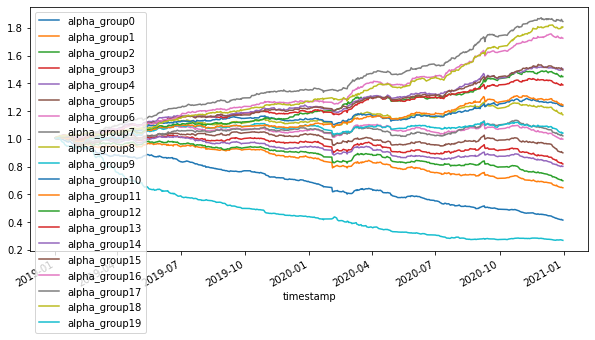

In [21]:
result.index = result.index.map(lambda x : pd.to_datetime(str(x)))
result.iloc[:,:20].plot(figsize=(10,5))

In [57]:
df.rename(columns = {"symbol":"ticker","timestamp":"date"},inplace=True)
df = df[['date','ticker',alpha_name]]
df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y%m%d').astype(int)
df.set_index("date",inplace=True)
df

,ticker,AlphaNetV1_Original_Input_1208
date,,
20190102,1,0.001571
20190103,1,0.060317
20190104,1,0.174096
20190107,1,0.301100
20190108,1,0.143749
...,...,...
20210623,601399,-0.001553
20210624,601399,-0.029387
20210625,601399,0.019083


In [58]:
df['ticker'] = df['ticker'].apply(lambda x : str(x).zfill(6))
data_frame = df.copy()
data_frame

,ticker,AlphaNetV1_Original_Input_1208
date,,
20190102,000001,0.001571
20190103,000001,0.060317
20190104,000001,0.174096
20190107,000001,0.301100
20190108,000001,0.143749
...,...,...
20210623,601399,-0.001553
20210624,601399,-0.029387
20210625,601399,0.019083


In [61]:
data_frame

,ticker,AlphaNetV1_Original_Input_1208
date,,
20190102,000001,0.001571
20190103,000001,0.060317
20190104,000001,0.174096
20190107,000001,0.301100
20190108,000001,0.143749
...,...,...
20210623,601399,-0.001553
20210624,601399,-0.029387
20210625,601399,0.019083


In [22]:
# time_df = pd.DataFrame(df['date'].drop_duplicates())
# time_df['year'] = time_df['date'].apply(lambda x : str(x.year))
# time_df['month'] = time_df['date'].apply(lambda x : str(x.month).zfill(2))
# time_df['day'] = time_df['date'].apply(lambda x : str(x.day).zfill(2))
# time_df['date_convert'] = time_df["year"] + time_df['month'] + time_df['day']
# time_df = time_df[["date","date_convert"]]
# df = pd.merge(df,time_df,left_on = "date" , right_on = "date",how="left")
# df['date'] = df['date_convert']
# df.drop('date_convert',axis=1,inplace=True)
# df.set_index("date",inplace=True)
# df

,date,date_convert
0,2019-01-02 09:30:00,20190102
1,2019-01-03 09:30:00,20190103
2,2019-01-04 09:30:00,20190104
3,2019-01-07 09:30:00,20190107
4,2019-01-08 09:30:00,20190108
...,...,...
112,2021-06-23 09:30:00,20210623
113,2021-06-24 09:30:00,20210624
114,2021-06-25 09:30:00,20210625
115,2021-06-28 09:30:00,20210628


In [71]:
config_path = r'/home/ShareFolder/lgc/Modules/Platform/config/combo_bt_template'
print('Loading the configuration from ' + config_path)
bt_price = "close"

start_date = '2019-01-02'
end_date = '2021-06-30'
configs = namespace.load_namespace(config_path)
configs.trading_type = 'long-only'
configs.data_format = 'dataframe'
configs.ti = 0
configs.trade_period = 0
configs.stock_percentage = False
configs.stock_num = 100
configs.transmission_rate = 0.0
configs.benchmark = "ZZ500"
configs.bt_price = bt_price
configs.universe = "Investable"
#configs.score_sorted = False
configs.keep_pos_percentile = 0.0

# df = standard_res.reset_index()

# df.columns = ['date', 'ticker', 'model']
# #df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y%m%d').astype(int)
# df.set_index('date', inplace=True)
#####################################

bt = BTDaily(configs, start_date=start_date, end_date= end_date)

bt.feed_data(data_frame)
bt.run()
start =int(datetime.strptime(start_date, '%Y-%m-%d').date().strftime('%Y%m%d'))
end = int(datetime.strptime(end_date, '%Y-%m-%d').date().strftime('%Y%m%d'))
df, df_final = bt.evaluate(evalRange=((start, end),))

  0%|                                                                                                                         | 0/605 [00:00<?, ?it/s]

Loading the configuration from /home/ShareFolder/lgc/Modules/Platform/config/combo_bt_template


Getting BT result for date: 20210630...: 100%|██████████████████████████████████████████████████████████████████████| 605/605 [00:45<00:00, 13.20it/s]



Back test summary: "short-only" mode
+-------------------+-------------+----------+-----------+------------+----------+-------------+--------------------------+-------------------+------------+
|      period       |  stock_num  |  return  |  ret_std  |  ret_year  |  sharpe  |  win_ratio  |      max_dd|period       |  max_dd_day|date  |  turnover  |
+===================+=============+==========+===========+============+==========+=============+==========================+===================+============+
| 20190102-20210630 |     222     |  39.77   |   13.88   |   14.27    |   0.99   |    54.30    | 13.56(20190404-20191112) |  4.89(20200203)   |   39.67    |
+-------------------+-------------+----------+-----------+------------+----------+-------------+--------------------------+-------------------+------------+
